In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import gc
import psutil
from matplotlib.ticker import PercentFormatter
from scipy import stats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


# EDA for training data 

This data holds information about each current loan applicant at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The application data comes with the TARGET indicating 1: client with payment difficulties, meaning he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample and 0: all other cases. 

In [2]:
train_df = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

## Checking target variable for imbalance in training data

<AxesSubplot:ylabel='Frequency'>

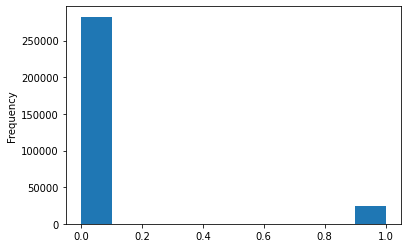

In [3]:
train_df['TARGET'].astype(int).plot.hist()

In [4]:
print("The number of Features in application train dataset :",train_df.shape[1])
print("The number of Rows in application Train dataset :",train_df.shape[0])

The number of Features in application train dataset : 122
The number of Rows in application Train dataset : 307511


## Looking into columns that have missing values in training data

In [5]:
train_df.columns[train_df.isna().sum() >0 ]

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMI

Many of the missing values are within columns about the applicants living situation or about the number of enquires the  Credit Bureau about the client before the currrent application 

## Looking at the most correlated and least correlated variables in the training data

The columns that are the least correlated are almost all columns that have missing values. Although this could be the reason they are not as correlated, it also means that the missing values are not as important for prediciting if the applicant should recieve a loan. The most positive correlated columns are DEF_60_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, and LIVE_CITY_NOT_WORK_CITY.

In [6]:
corr = train_df.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


## Categorical Variable Distributions in the training data set

In [7]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

### Categorical columns in training data set

In [8]:
catCols = [col for col in train_df.columns if train_df[col].dtype=="O"]
catCols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

### Distributions of types of loans people are applying for in the training data set

Most of the applications are for cash loans 

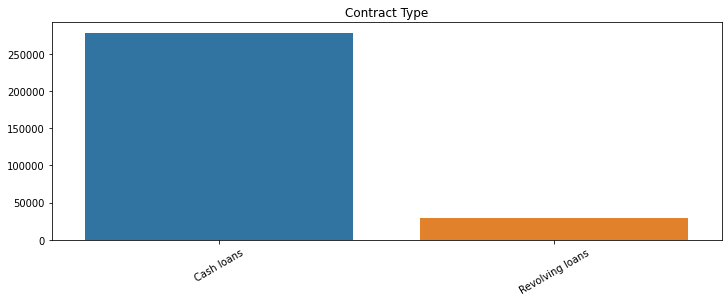

In [9]:
plot_categorical(data=train_df, col='NAME_CONTRACT_TYPE', size=[12 ,4], xlabel_angle=30, title='Contract Type')

### Distribution of occupation type of applicants in the training data set

Most applicants are laborers, sales staff, core staff, managers, and drivers.

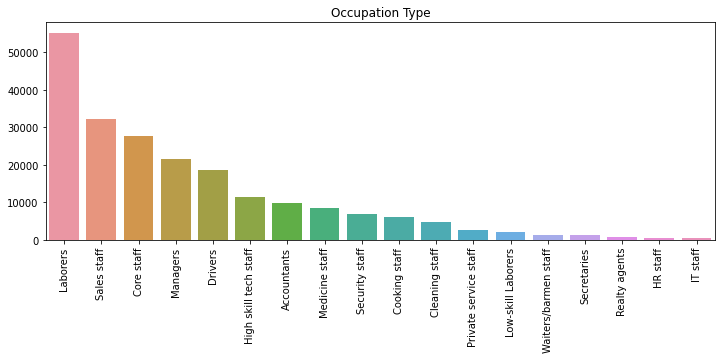

In [10]:
plot_categorical(data=train_df, col='OCCUPATION_TYPE', size=[12 ,4],  xlabel_angle=90, title='Occupation Type')

### Distribution of types of housing the applicants live in the training data set

Almost every applicant lives in a block of flats.

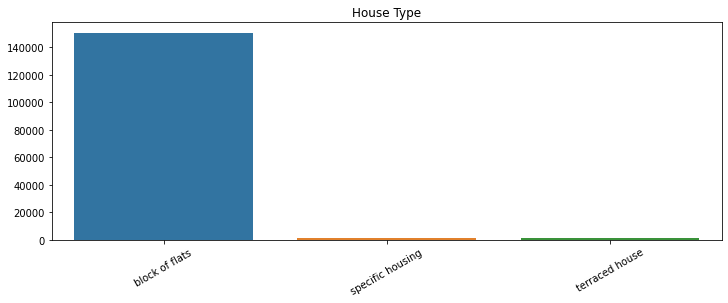

In [11]:
plot_categorical(data=train_df, col='HOUSETYPE_MODE', size=[12 ,4], xlabel_angle=30, title='House Type')

### Distribution of education that applicants have recieved in the training data set
A majority of the applicants have gotten secondary education 

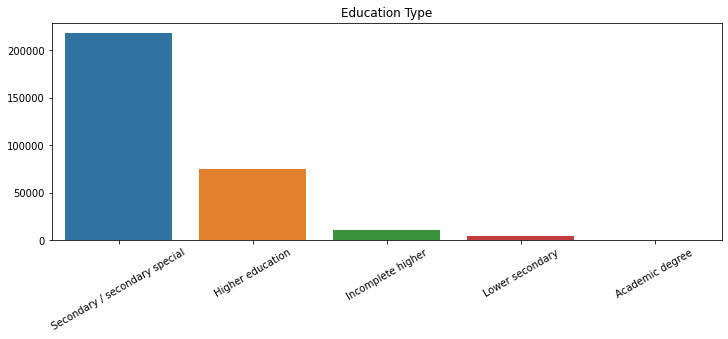

In [12]:
plot_categorical(data=train_df, col='NAME_EDUCATION_TYPE', size=[12 ,4], xlabel_angle=30, title='Education Type')

### Distribution of the family status of the applicants in the training data set

A majority of the applicants are married. 


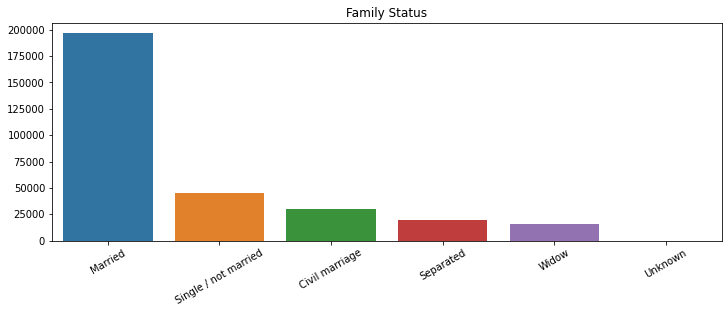

In [13]:
plot_categorical(data=train_df, col='NAME_FAMILY_STATUS', size=[12 ,4], xlabel_angle=30, title='Family Status')

### Looking further into if the married couples have children in the training data set 

Most people who take out loans are married and do not have children 


In [14]:
pd.crosstab(train_df.CNT_CHILDREN, train_df.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
CNT_CHILDREN,,,,,,
0,20947,126575,14132,38810,2,14905
1,6588,43696,4389,5578,0,868
2,1936,22496,1111,958,0,248
3,262,3190,122,85,0,58
4,33,370,12,9,0,5
5,5,74,2,1,0,2
6,2,17,1,0,0,1
7,1,5,0,0,0,1
8,0,2,0,0,0,0


### Further look into the gender of applicants and likelihood of paying back loans 

Mostly women take out loans and are more likely to pay them back 


In [15]:
pd.crosstab(train_df.TARGET, train_df.CODE_GENDER, dropna=False)

CODE_GENDER,F,M,XNA
TARGET,,,
0,188278,94404,4
1,14170,10655,0


## Numerical Variables Distributions in the training data set

### Looking into the distribution of ages of the applicants 

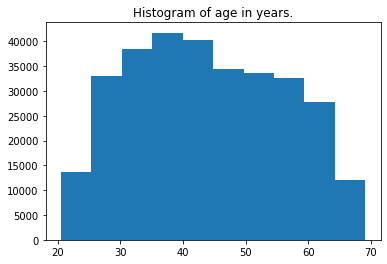

In [16]:
train_df['age'] = train_df['DAYS_BIRTH'] / -365
plt.hist(train_df['age']);
plt.title('Histogram of age in years.');

### Looking into the distribution of the amount of years of employment applicants have

Most people do not work or have been employed a short period of time 

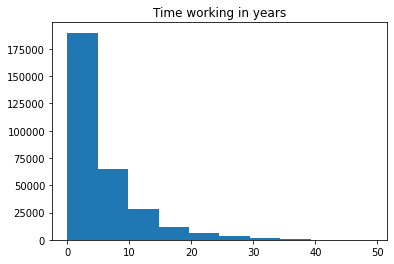

In [17]:
#change the 365243 to 0 as it is a null value 
train_df.loc[train_df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
#find the yeras employed rather than the number of days 
train_df['years_employed'] = train_df['DAYS_EMPLOYED'] / -365
plt.hist(train_df['years_employed']);
plt.title('Time working in years');

### Looking at the distribution of the amount of credit the applicants are asking for 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


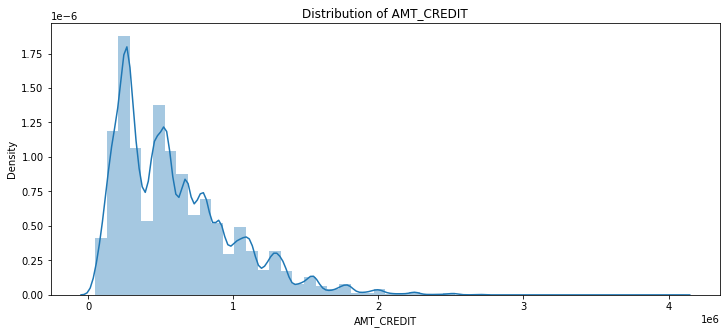

In [18]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(train_df["AMT_CREDIT"])

### Looking at the distribution of total income the applicants have 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


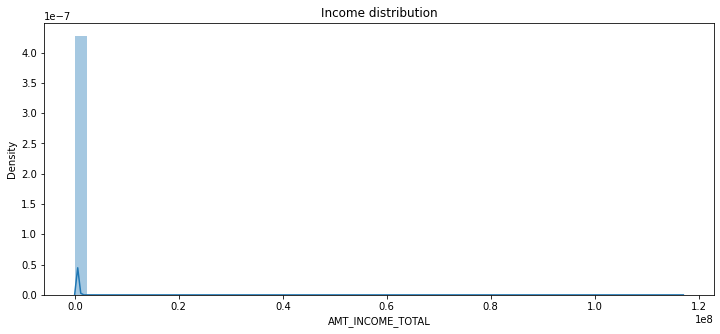

In [19]:
plt.figure(figsize=(12,5))
plt.title("Income distribution")
ax = sns.distplot(train_df["AMT_INCOME_TOTAL"])

Due to a few incomes being over $1 million the above graph got very skewed. After filtering the outliers out, the below graph gives a better view of the distribution of incomes.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


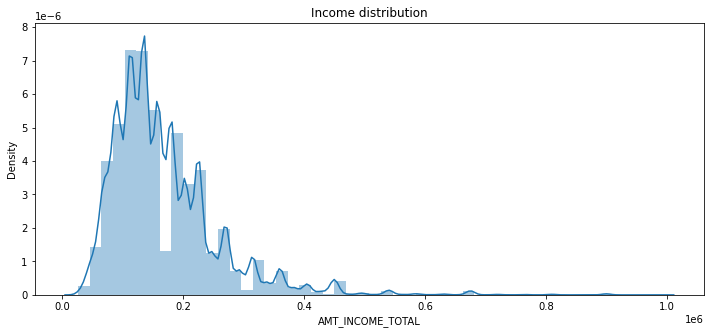

In [20]:
train_income = train_df[train_df['AMT_INCOME_TOTAL'] < 1000000]
plt.figure(figsize=(12,5))
plt.title("Income distribution")
ax = sns.distplot(train_income["AMT_INCOME_TOTAL"])

In [21]:
del train_df
del train_income
del catCols
del corr
gc.collect()

11963

# EDA for Previous Applications Data

This data contains previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PRE

In [22]:
train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
prev = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')

In [23]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

## Missing Values in Previous Applications Data

Rate interest columns have very few values 

<AxesSubplot:>

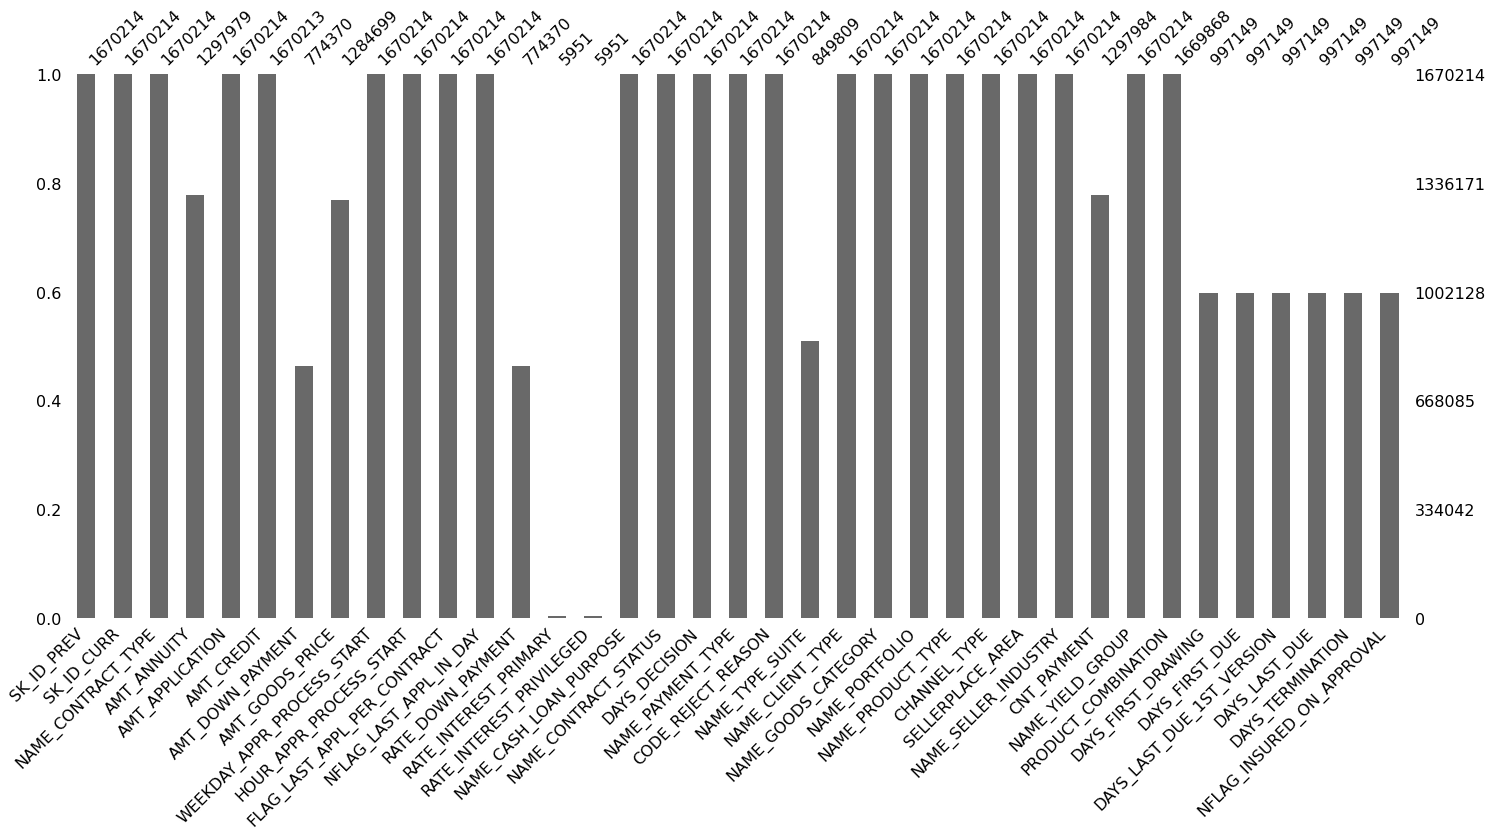

In [24]:
msno.bar(prev)

## Distribution of different categorical variables in Previous Applications Data

In [25]:
def plot_data(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

### Contract Types in Previous Applications Data


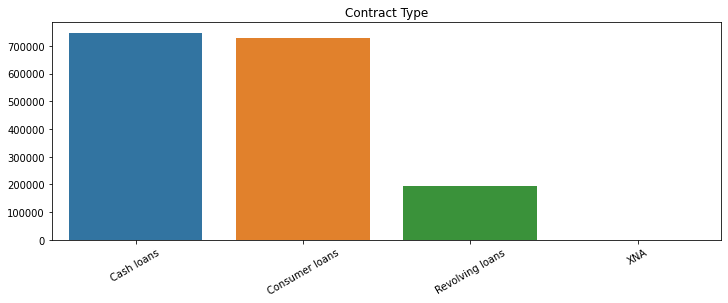

In [26]:
plot_data(data=prev, col='NAME_CONTRACT_TYPE', size=[12 ,4], xlabel_angle=30, title='Contract Type')

### Payment Type in Previous Applications Data

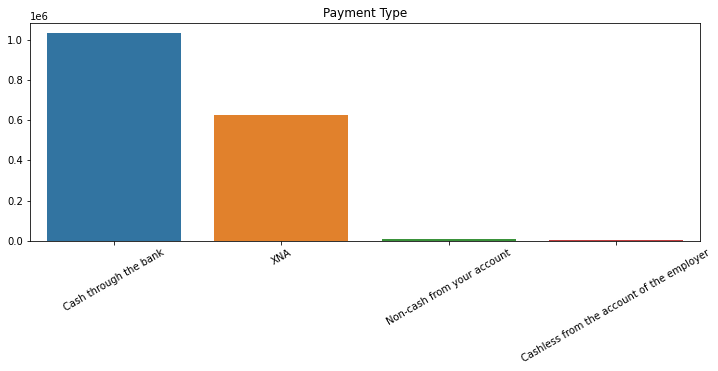

In [27]:
plot_data(data=prev, col='NAME_PAYMENT_TYPE', size=[12 ,4], xlabel_angle=30, title='Payment Type')

### What Previous Loans were Used For in Previous Applications Data

Most of the loans are for unknown goods 


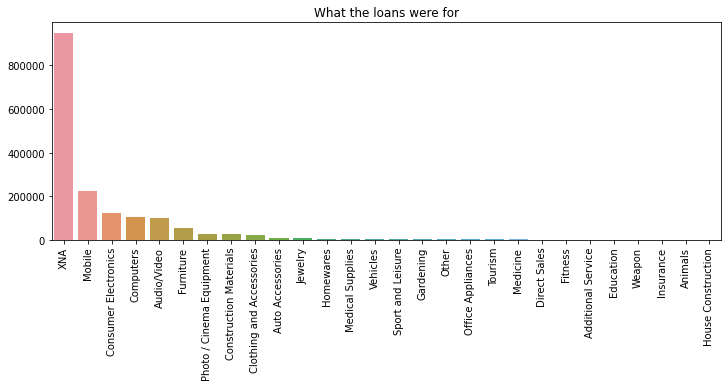

In [28]:
plot_data(data=prev, col='NAME_GOODS_CATEGORY', size=[12 ,4], xlabel_angle=90, title='What the loans were for')

### Client Type for Previous Applicants

Most of the current applicants are repeat customers 


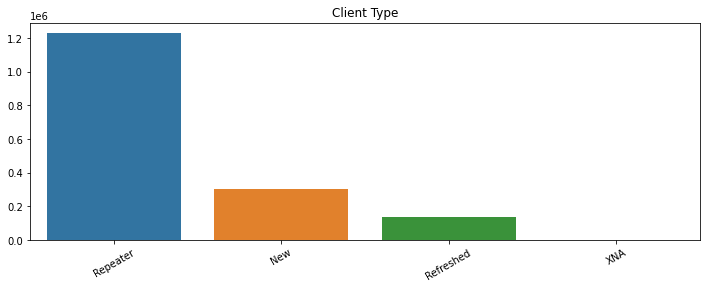

In [29]:
plot_data(data=prev, col='NAME_CLIENT_TYPE', size=[12 ,4], xlabel_angle=30, title='Client Type')

### Distribution of Amount Previous Applications were for

There are a few outliers for an application for almost $7 million. After removing this outlier, we see that most loan applications are below half a million 


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


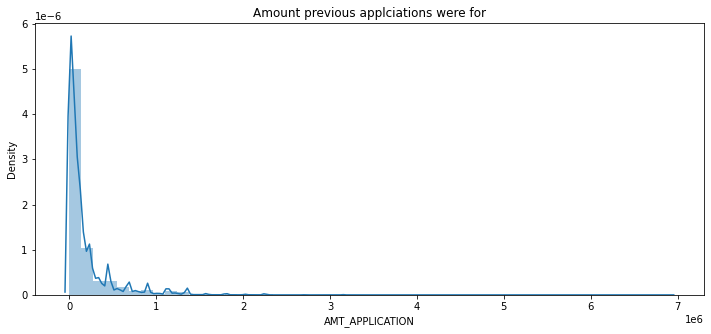

In [30]:
plt.figure(figsize=(12,5))
plt.title("Amount previous applciations were for")
ax = sns.distplot(prev["AMT_APPLICATION"])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


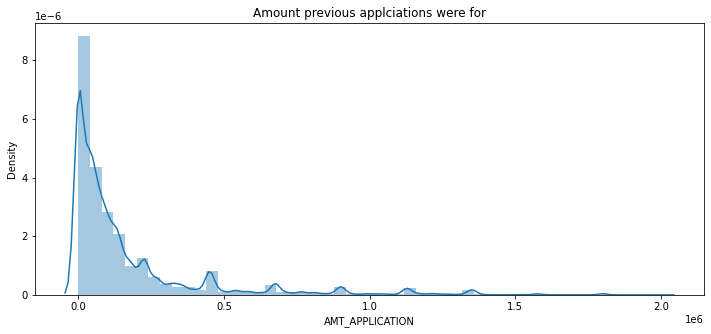

In [31]:
#filtering out the outlier loans of over $2 mil 
prev_amt = prev[prev['AMT_APPLICATION'] < 2000000]
plt.figure(figsize=(12,5))
plt.title("Amount previous applciations were for")
ax = sns.distplot(prev_amt["AMT_APPLICATION"])

## Exploring which types of applicants do not pay in Previous Loan Data

When target is 1, the applicant had payment difficulties. When target is 0, the applicant did not have payment difficulties. For applicants who did not have payment difficulties, we see that they previously had consumer and cash loans, most of their previous loans were approved, and they were often repeating customers.

In [32]:
prev_merged = train.iloc[:,:2].merge(prev, on = 'SK_ID_CURR', how = 'left')
object_columns = prev_merged.dtypes[prev_merged.dtypes=='object'].index.tolist()

In [33]:
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=90)

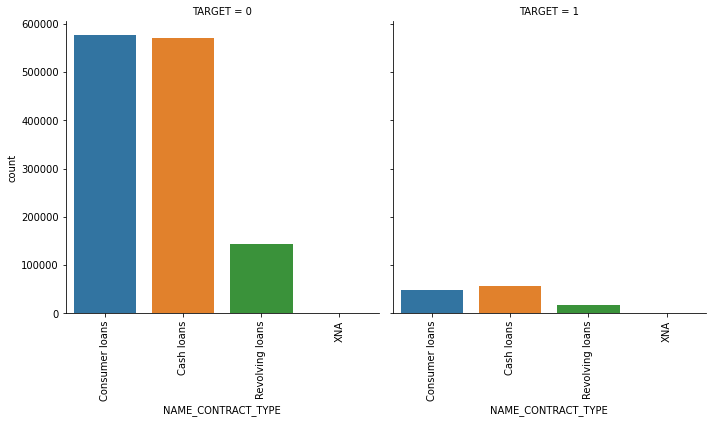

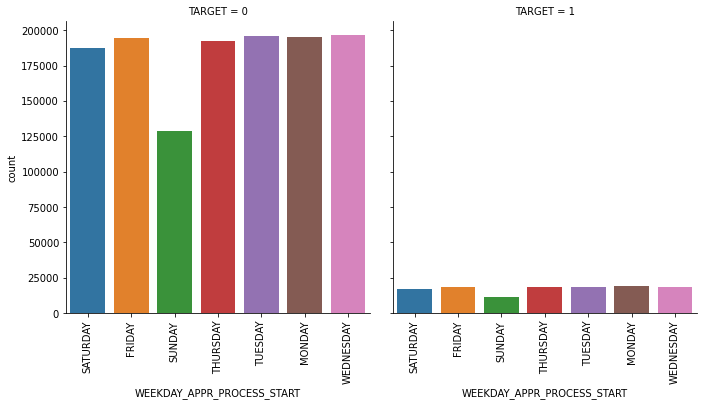

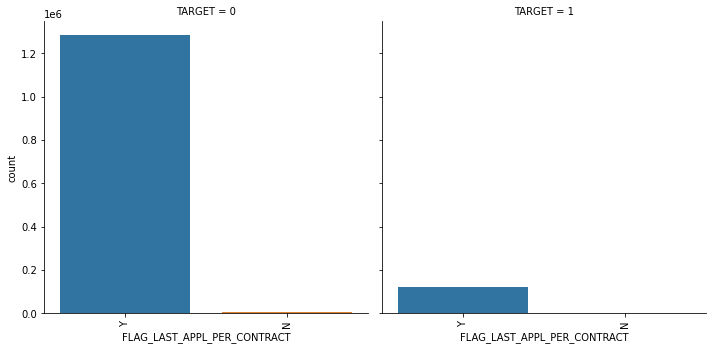

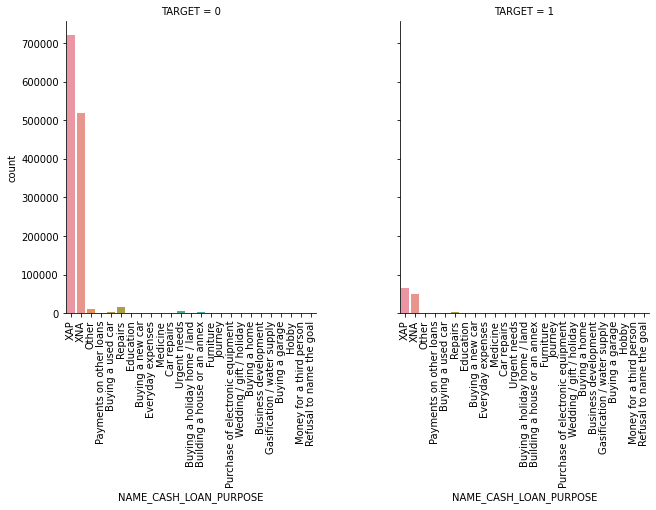

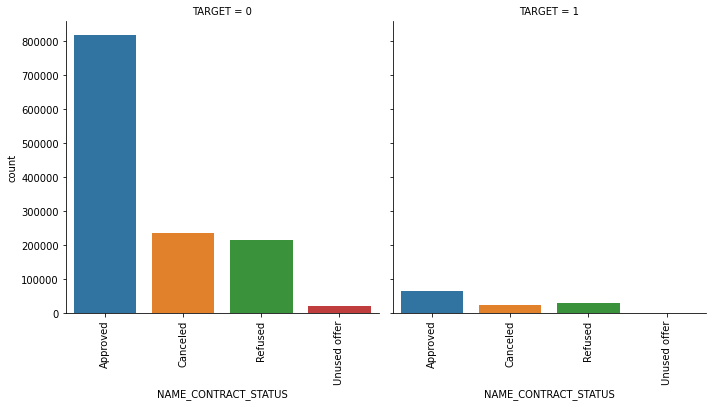

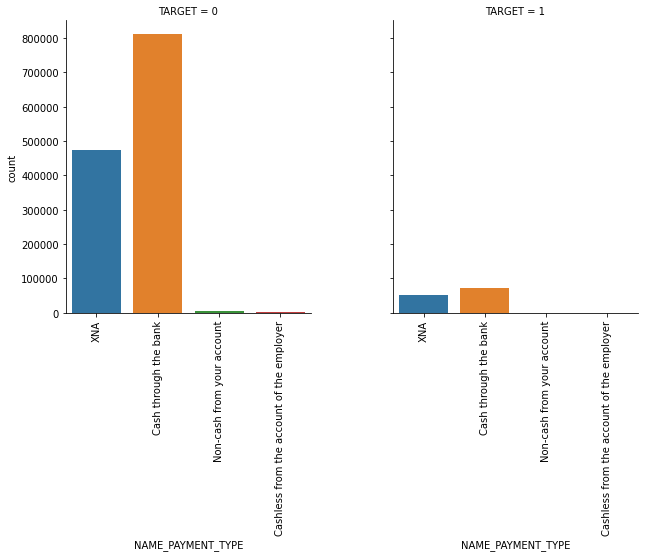

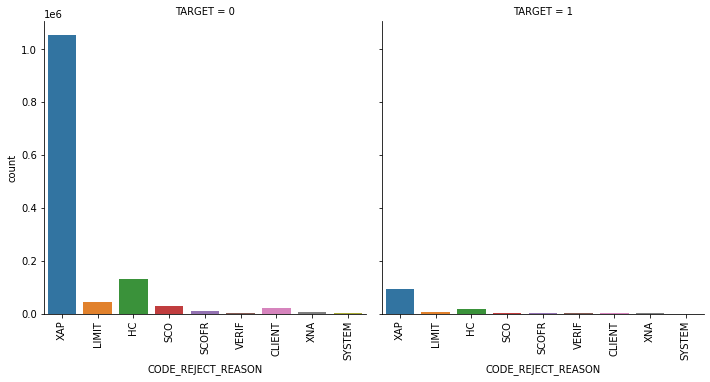

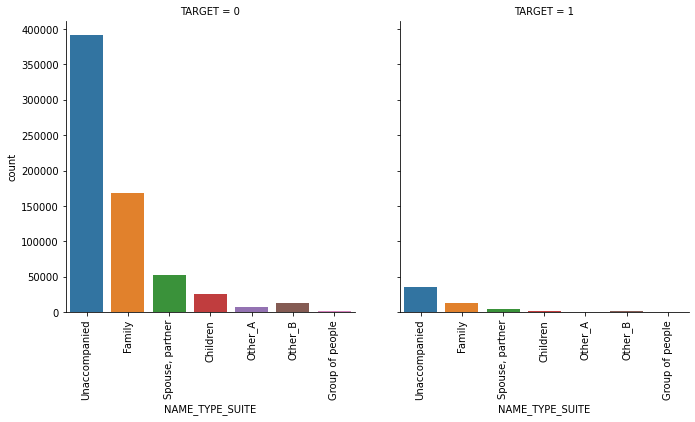

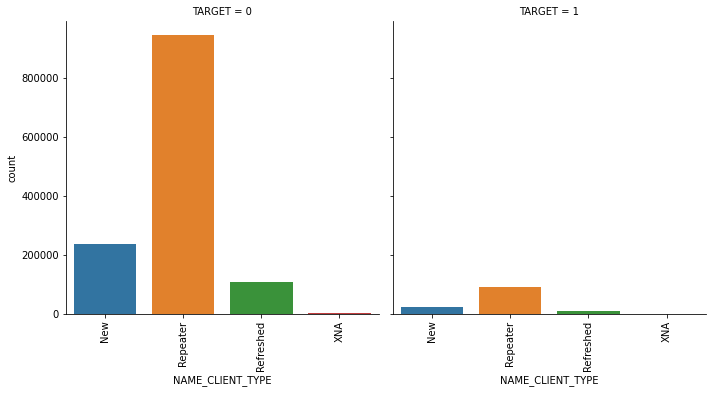

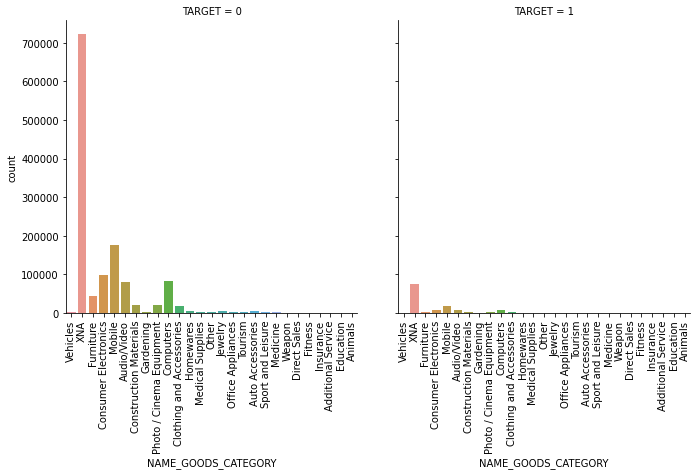

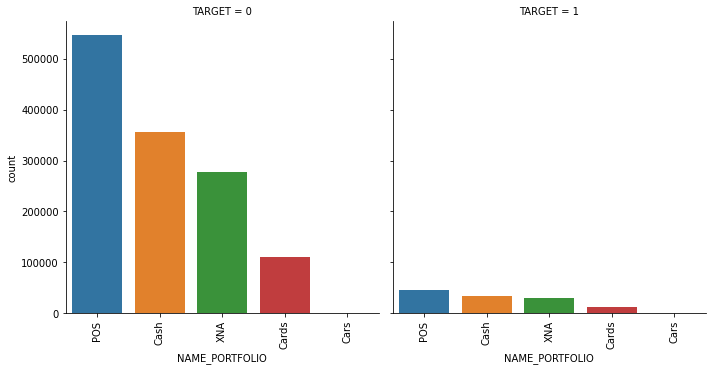

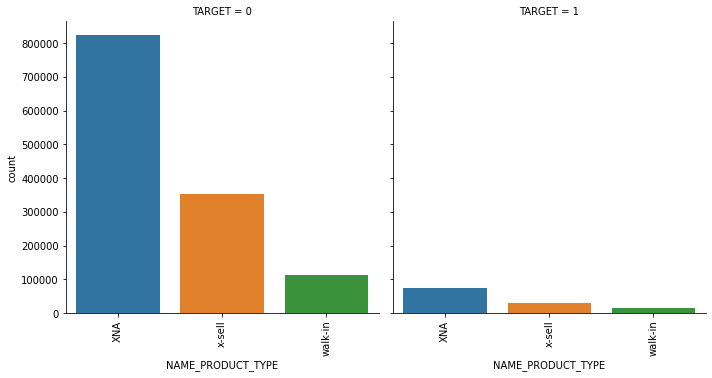

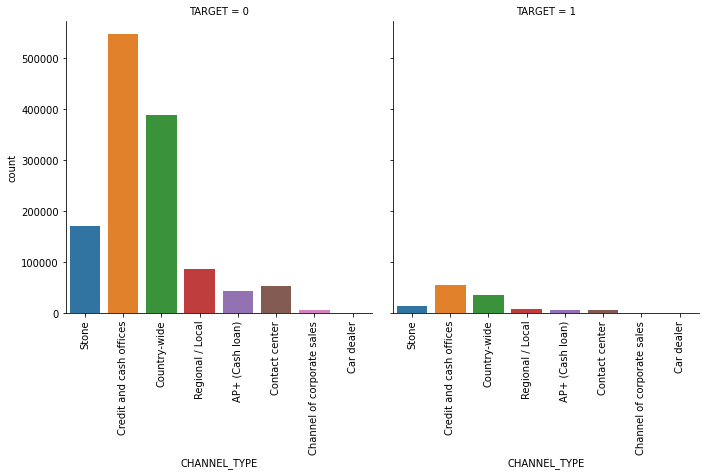

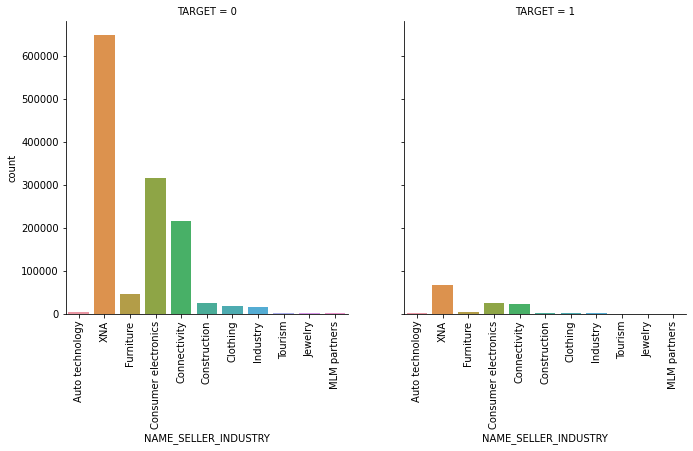

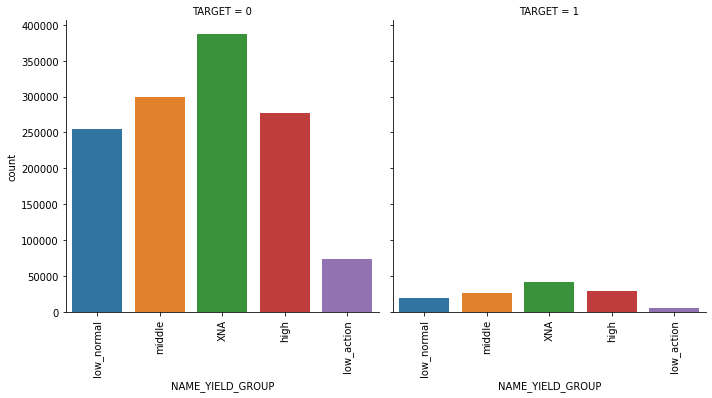

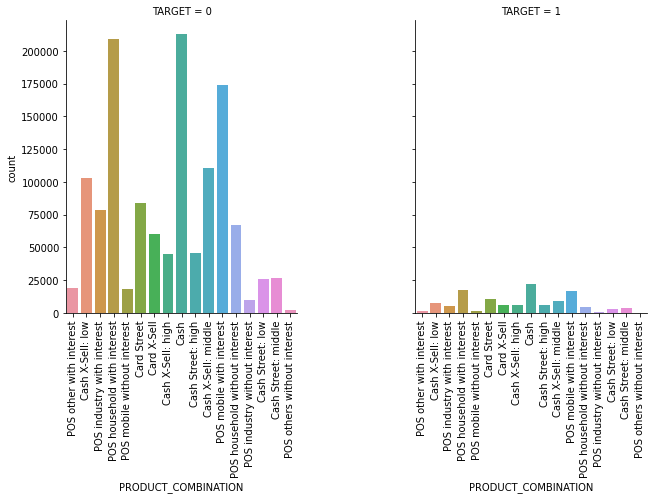

In [34]:
show_category_by_target(prev_merged, object_columns)

## Previous Loan Applicant Features that are correlated with Target Variable

We see that AMT_ANNUITY and CNT_PAYMENT are modeerately correlated with our target variable. 

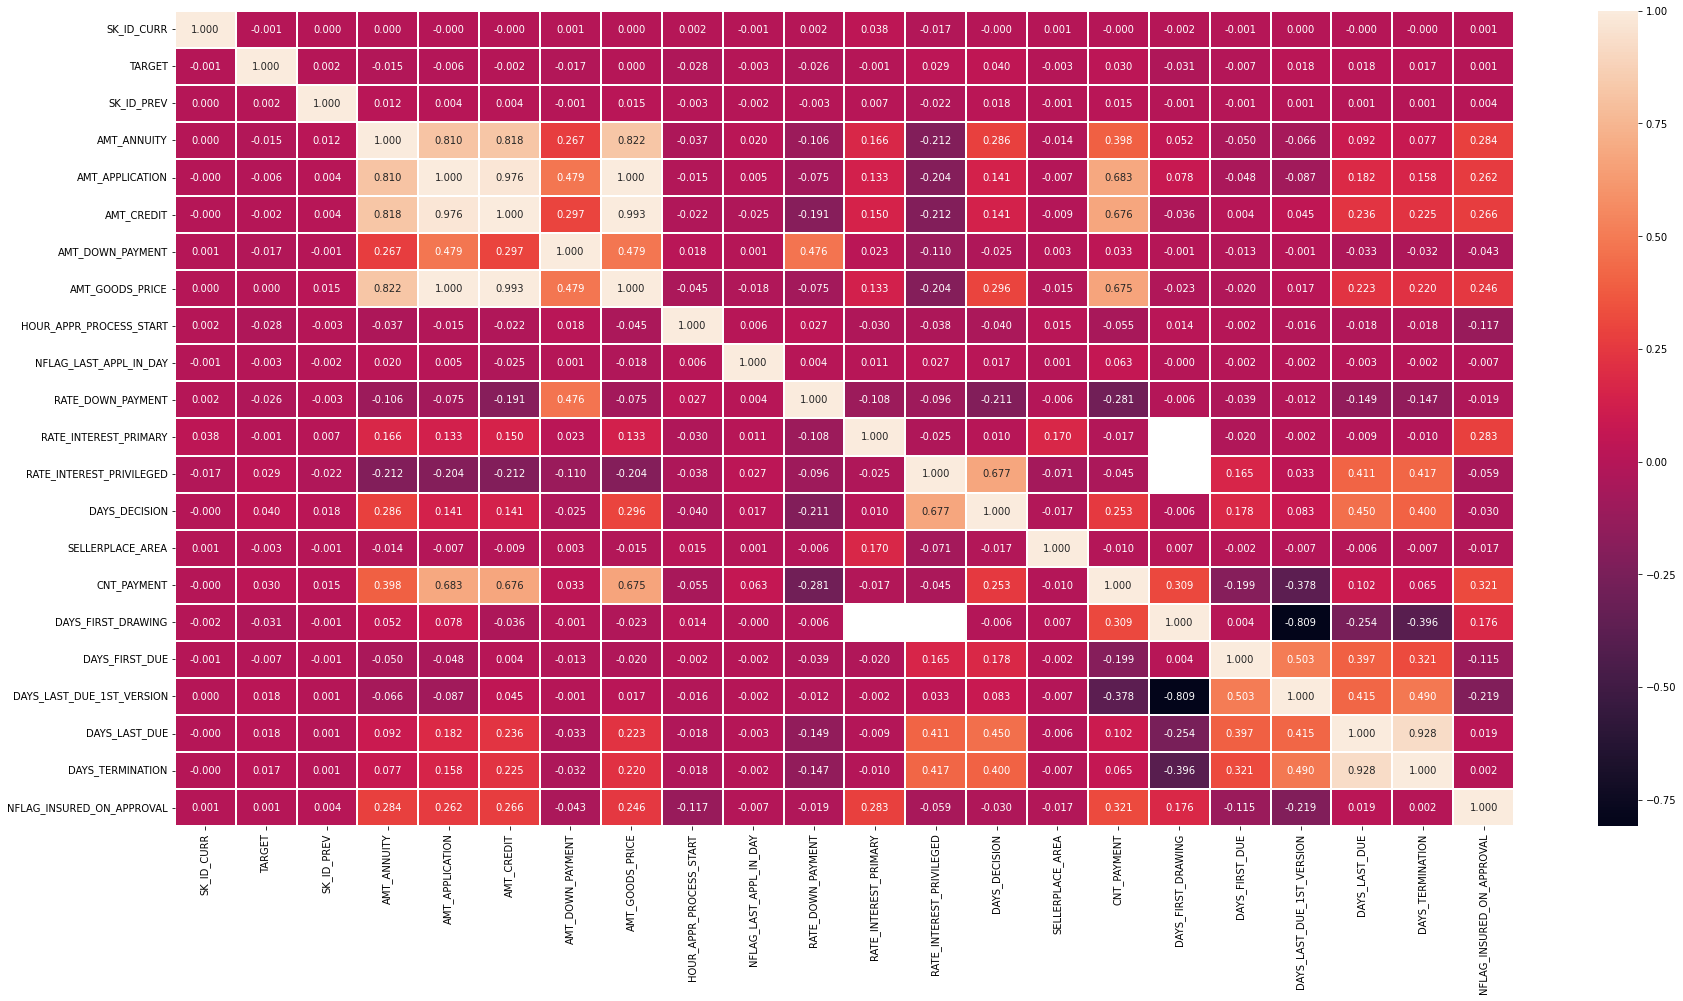

In [35]:
corr = prev_merged.corr()
plt.figure(figsize=(30,15))
ax = sns.heatmap(corr, linewidths=.2,annot=True,fmt=".3f")

In [36]:
# clean up memory
del train
del prev
del prev_merged

# Exploration of POS_CASH_BALANCE Data

This data set consists of monthly balances for an applicant's previous POS (point of sales) and cash loans with Home Credit. Applicant's can have multiple previous POS and cash loans. The data has one row for each month's balance corresponding to an applicant's previous POS or cash loan. We have information about the number of installments an applicant paid on the previous loan, number of future installments for each month, the contract status during each month, and days past due for each month.

In [37]:
cash_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
cash_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


## Snapshot of POS_CASH_BALANCE data for a single current applicant

In [38]:
cash_balance[cash_balance['SK_ID_CURR'] == 367990].sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2505374,2671131,367990,-83,6.0,6.0,Active,0,0
6249476,2671131,367990,-82,6.0,5.0,Active,0,0
7954736,2671131,367990,-81,6.0,4.0,Active,0,0
7225088,2671131,367990,-80,6.0,3.0,Active,0,0
2743194,2671131,367990,-79,6.0,2.0,Active,0,0
5893829,2671131,367990,-78,6.0,1.0,Active,0,0
580429,2671131,367990,-77,6.0,0.0,Active,0,0
2795749,2671131,367990,-76,6.0,0.0,Completed,0,0
682460,1715348,367990,-34,36.0,36.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


## Number of Unique Previous POS or CASH Loans

There are 936,325 previous loans in our data relating to 337,252 current applications.

In [39]:
cash_balance.nunique()

SK_ID_PREV               936325
SK_ID_CURR               337252
MONTHS_BALANCE               96
CNT_INSTALMENT               73
CNT_INSTALMENT_FUTURE        79
NAME_CONTRACT_STATUS          9
SK_DPD                     3400
SK_DPD_DEF                 2307
dtype: int64

## Contract Statuses of POS and CASH loans

Most of the monthly records are active loans.

In [40]:
status = cash_balance.groupby('NAME_CONTRACT_STATUS').size()
status

NAME_CONTRACT_STATUS
Active                   9151119
Amortized debt               636
Approved                    4917
Canceled                      15
Completed                 744883
Demand                      7065
Returned to the store       5461
Signed                     87260
XNA                            2
dtype: int64

## Missing Values in POS_CASH_BALANCE

There are 26,071 missing values in the number of installments an applicant paid and the number of future installments for each month.

In [41]:
cash_balance.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

We will have to aggregate this POS_CASH_BALNCE data in order to combine it with the application training set. When predicting whether or not an applicant will pay back a loan, we care about the number of future installments that an applicant has in the last month of their previous loan. In other words, we care if the applicant still has a previous loan that they are still paying off one month before they applied for the laon (MONTHS_BALANCE = -1). There are only 462 cases where there is a missing value in the number of future installments for a previous loan that an applicant might still be paying off. This is only 0.04% of the previous loans we have in our data (462/936325), so we can fill in these missing values with zero. We do not need to be concerned that we will distort the data by representing these future installments as zero when there could still be future installments on these loans because it is such a small proportion of previous loans. These missing values occur when the contract status is approved, signed, or returned to the store.

In [42]:
cash_balance[(cash_balance['MONTHS_BALANCE'] == -1) & (cash_balance['CNT_INSTALMENT'].isna() == True)]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
54227,1907942,350092,-1,NaN,NaN,Returned to the store,0,0
194481,1922993,126350,-1,NaN,NaN,Signed,0,0
679600,1430322,273327,-1,NaN,NaN,Signed,0,0
721015,1026268,250375,-1,NaN,NaN,Signed,0,0
770725,1235441,205502,-1,NaN,NaN,Signed,0,0
...,...,...,...,...,...,...,...,...
9956855,2066117,109633,-1,NaN,NaN,Signed,0,0
9959196,2467053,256515,-1,NaN,NaN,Signed,0,0
9959307,2474422,103770,-1,NaN,NaN,Signed,0,0
9973620,1229527,386805,-1,NaN,NaN,Signed,0,0


Text(0.5, 1.0, 'Statuses of Latest POS or CASH Loans')

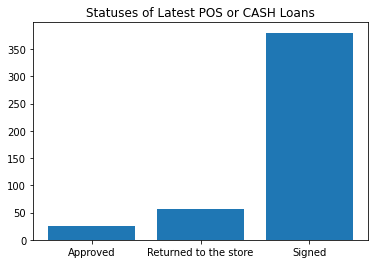

In [43]:
x = cash_balance[(cash_balance['MONTHS_BALANCE'] == -1) & (cash_balance['CNT_INSTALMENT'].isna() == True)].groupby('NAME_CONTRACT_STATUS').size()
plt.bar(x.index, x)
plt.title('Statuses of Latest POS or CASH Loans')

In [44]:
cash_balance['CNT_INSTALMENT_FUTURE'] = cash_balance['CNT_INSTALMENT_FUTURE'].fillna(0)

## Days Past Due for POS or CASH Loans

About 2500 applicants had previous loans with a maximum days past due between 100 and 500 days. We have some outliers where there were loans with more than 3,000 maximum days past due. We hope that our model will predict that these applicants are unlikely to pay back a loan.

In [45]:
# Creating a non-zero flag for columns DPD
cash_balance['SK_DPD_flag'] = cash_balance['SK_DPD'].apply(lambda x: 1 if x>0 else 0)
cash_balance['SK_DPD_DEF_flag'] = cash_balance['SK_DPD_DEF'].apply(lambda x: 1 if x>0 else 0)

# Aggregating the DPD columns to create average, max, and % of non zero values at SK_ID_CURR level
rollup1 = cash_balance.groupby(['SK_ID_CURR'],as_index=False).agg(avg_DPD = ('SK_DPD','mean'),
                                       max_DPD = ('SK_DPD','max'),
                                       per_DPD = ('SK_DPD_flag','mean'),
                                       avg_DPD_DEF = ('SK_DPD_DEF','mean'),
                                       max_DPD_DEF = ('SK_DPD_DEF','max'),
                                       per_DPD_DEF = ('SK_DPD_DEF_flag','mean'))

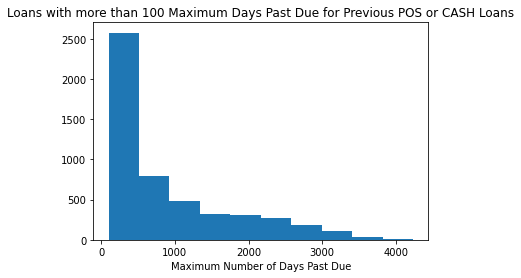

In [46]:
x = rollup1[rollup1['max_DPD'] > 100]
plt.hist(x['max_DPD'])
plt.xlabel('Maximum Number of Days Past Due')
plt.title('Loans with more than 100 Maximum Days Past Due for Previous POS or CASH Loans')
plt.show()

## Total Future Installments for Latest POS or CASH Loans

Most current applicants had fewer than 20 future installments on their previous loans. If they had zero future installments, we can assume they have no current loans with Home Credit. There are a some outliers where an applicant had more than 40 future installments, and the max number of future installments an applicant had is over 120.

In [47]:
max_month_data = cash_balance.groupby(['SK_ID_CURR','SK_ID_PREV'],as_index=False).agg(MONTHS_BALANCE = ('MONTHS_BALANCE', 'max'))

prev_appl_wise_data = pd.merge(max_month_data,cash_balance,how='inner',on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])

rollup2 = prev_appl_wise_data.groupby(['SK_ID_CURR'],as_index=False).agg(total_future_installments = ('CNT_INSTALMENT_FUTURE','sum'),
                                                                         total_past_applications = ('SK_ID_PREV','count'))

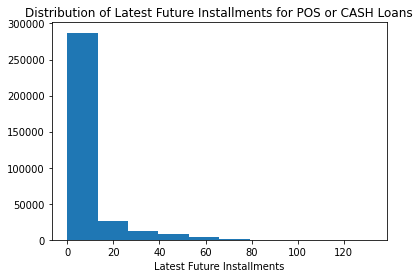

In [48]:
plt.hist(rollup2['total_future_installments'])
plt.xlabel('Latest Future Installments')
plt.title('Distribution of Latest Future Installments for POS or CASH Loans')
plt.show()

## Total Past Applications for POS or CASH Loans

Most applicants had less than five previous POS or CASH loans with Home Credit. There are some outliers where an applicant had more than 10 applicatiosn, and the max number of past applications an applicant had is around 25.

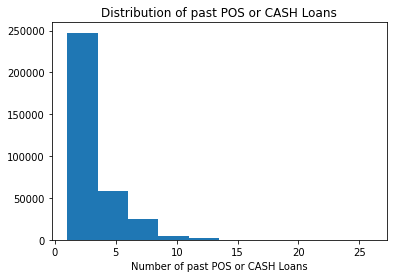

In [49]:
plt.hist(rollup2['total_past_applications'])
plt.xlabel('Number of past POS or CASH Loans')
plt.title('Distribution of past POS or CASH Loans')
plt.show()

## Latest Contract Statuses for POS or CASH Loans

A majority of the latest previous POS or CASH loans have a status of active or completed.

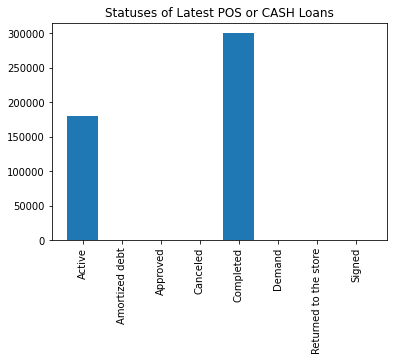

In [50]:
rollup3 = prev_appl_wise_data.groupby(['SK_ID_CURR','NAME_CONTRACT_STATUS'],as_index=False).agg(applications = ('SK_ID_PREV','count'))
x = rollup3.groupby('NAME_CONTRACT_STATUS').size()
plt.bar(x.index, x)
plt.title('Statuses of Latest POS or CASH Loans')
plt.tick_params(axis='x', labelrotation = 90)

## Distribution of TARGET Variable for Previous POS or CASH Loans with Home Credit

Ninety-two percent of the POS or CASH loans were for applicants who were classified as having payment difficulties (target = 0).

In [51]:
rollup3 = rollup3.pivot_table(index=['SK_ID_CURR'],columns='NAME_CONTRACT_STATUS',values='applications',fill_value=0).reset_index()
cash_balance_agg = rollup1.merge(rollup2,on='SK_ID_CURR').merge(rollup3,on='SK_ID_CURR')
cash_balance_agg

application_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
cash_balance_targ = cash_balance_agg.merge(right=application_train[['SK_ID_CURR','TARGET']], how='inner', on='SK_ID_CURR')
cash_balance_targ.index = cash_balance_targ['SK_ID_CURR']
cash_balance_targ.drop(columns='SK_ID_CURR', inplace=True)
cash_balance_targ

cash_balance_targ['TARGET'].value_counts()/len(cash_balance_targ['TARGET'])

0    0.918392
1    0.081608
Name: TARGET, dtype: float64

## Correlations of POS or CASH Loan Features with Target Variable

We can see that most of the features are not highly correlated with the target variable.

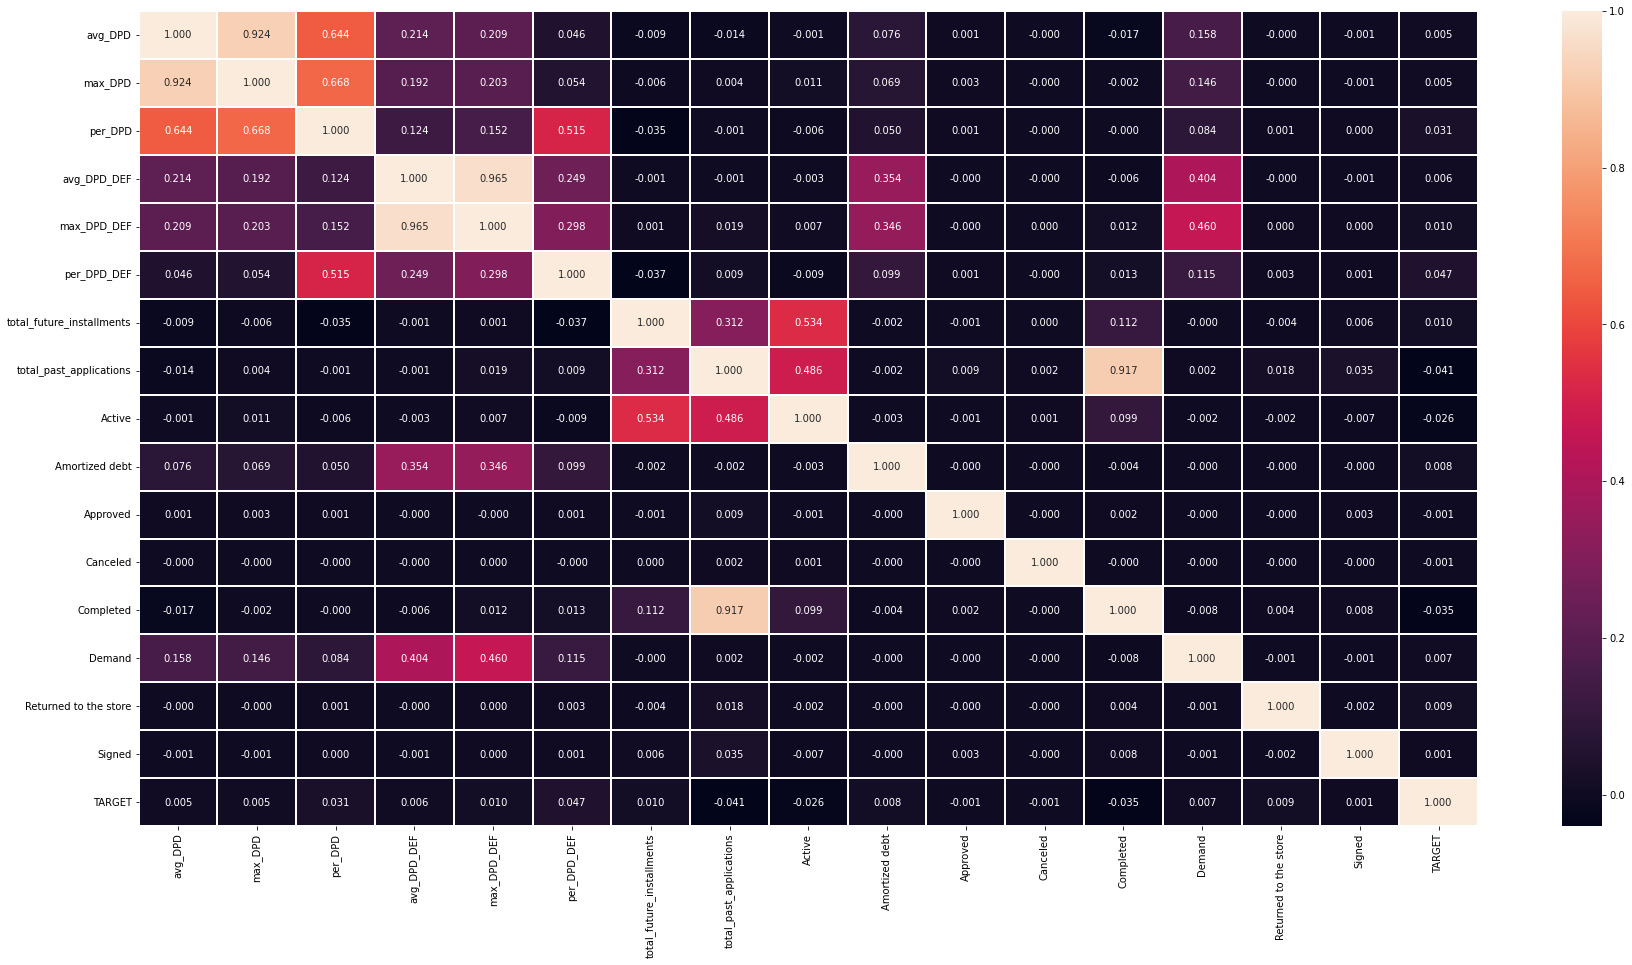

In [52]:
corr = cash_balance_targ.corr()
plt.figure(figsize=(30,15))
ax = sns.heatmap(corr, linewidths=.2,annot=True,fmt=".3f")

In [53]:
# clean up memory
del rollup1
del rollup2
del rollup3
del max_month_data
del prev_appl_wise_data
del cash_balance
del cash_balance_agg
del cash_balance_targ
del x
del status
del corr

gc.collect()

36611

# EDA of Installment Payments Data

The data contains installment details giving the repayment history for the credits that were previously disbursed. There is one row for every payment made and one row for every missed payment for previous loans the current applicant had with Home Credit. There are more than 13.5 million observations with 8 columns including Current ID and Previous ID which contains data of 339,587 unique customers (based on current ID).

In [54]:
data = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
data.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [55]:
data.shape

(13605401, 8)

## Missing values in Installment Payments Data

The missing values of DAYS_ENTRY_PAYMENT and AMT_PAYMENT pertain to the same group of customers, with a count of 2905 missing values in each column.

In [56]:
data.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [57]:
data[(data['DAYS_ENTRY_PAYMENT'].isna() == True) & data['AMT_PAYMENT'].isna() == True]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3764207,1531600,103793,1.0,7,-668.0,NaN,49741.020,NaN
3764208,1947105,159974,1.0,24,-36.0,NaN,22849.515,NaN
3764209,1843773,167270,1.0,22,-20.0,NaN,48092.355,NaN
3764210,1691592,192536,1.0,5,-2561.0,NaN,7675.425,NaN
3764211,1531299,157088,0.0,11,-1847.0,NaN,67.500,NaN
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


## Distribution of NUM_INSTALMENT_NUMBER variable

Most applicants have less than 50 installments, with a few outliers of over 200 installments.

Text(0, 0.5, 'Count of SK_CURR_ID')

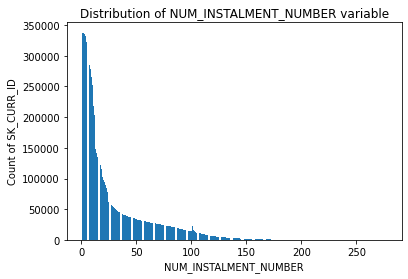

In [58]:
x = data.groupby('NUM_INSTALMENT_NUMBER')['SK_ID_CURR'].nunique()
plt.bar(x.index, x)
#plt.xlim(0,)
plt.title('Distribution of NUM_INSTALMENT_NUMBER variable')
plt.xlabel('NUM_INSTALMENT_NUMBER')
plt.ylabel('Count of SK_CURR_ID')

## Feature Creation in Installment Payments Data

In [59]:
data['PAYMENT_PERCENT'] = round(data['AMT_PAYMENT'] / data['AMT_INSTALMENT']*100, 2)
data['PAYMENT_DIFF'] = data['AMT_INSTALMENT'] - data['AMT_PAYMENT']
data['DPD'] = data['DAYS_ENTRY_PAYMENT'] - data['DAYS_INSTALMENT']
data['DBD'] = data['DAYS_INSTALMENT'] - data['DAYS_ENTRY_PAYMENT']
data['DPD'] = data['DPD'].apply(lambda x: x if x > 0 else 0)
data['DBD'] = data['DBD'].apply(lambda x: x if x > 0 else 0)
data

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_PERCENT,PAYMENT_DIFF,DPD,DBD
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,100.00,0.000,0.0,7.0
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,100.00,0.000,0.0,0.0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,100.00,0.000,0.0,0.0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,100.00,0.000,0.0,8.0
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,99.79,4.455,17.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN,NaN,NaN,0.0,0.0
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN,NaN,NaN,0.0,0.0
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN,NaN,NaN,0.0,0.0
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN,NaN,NaN,0.0,0.0


## Infifnity Values in Installment Payments Data

There are some infinity values in the PAYMENT_PERCENT column because we might divide by zero in some cases when creating this column. We will replace these infinity values with zero.

In [60]:
data.max()

SK_ID_PREV                2843499.000
SK_ID_CURR                 456255.000
NUM_INSTALMENT_VERSION        178.000
NUM_INSTALMENT_NUMBER         277.000
DAYS_INSTALMENT                -1.000
DAYS_ENTRY_PAYMENT             -1.000
AMT_INSTALMENT            3771487.845
AMT_PAYMENT               3771487.845
PAYMENT_PERCENT                   inf
PAYMENT_DIFF              2424726.405
DPD                          2884.000
DBD                          3189.000
dtype: float64

In [61]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data['PAYMENT_PERCENT'].fillna(0, inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


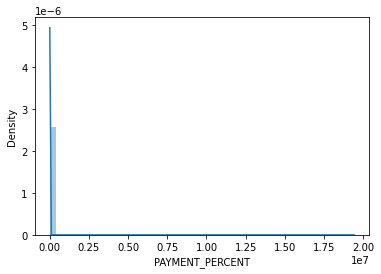

In [62]:
ax = sns.distplot(data["PAYMENT_PERCENT"].dropna())
#plt.xlim(0, 1.75)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


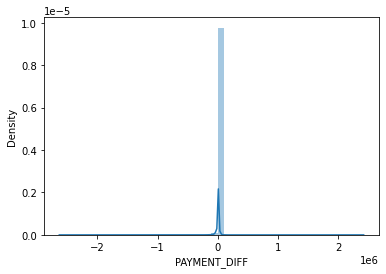

In [63]:
ad = sns.distplot(data["PAYMENT_DIFF"].dropna())

## Correlations of Previous Installment Features with Target Variable

Not many of the features are highly correlated with the target variable.

In [64]:
aggregations = {'NUM_INSTALMENT_VERSION': ['nunique'],
                'DPD': ['min','max', 'mean', 'sum'],
                'DBD': ['min','max', 'mean', 'sum'],
                'PAYMENT_PERCENT': ['min','max', 'mean', 'sum'],
                'PAYMENT_DIFF': ['min','max', 'mean', 'sum'],
                'AMT_INSTALMENT': ['min','max', 'mean', 'sum'],
                'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
                'DAYS_ENTRY_PAYMENT': ['min','max', 'mean', 'sum']}

group = data.groupby('SK_ID_CURR')
data_agg= group.agg(aggregations)
data_agg.columns = ['instalment_version_unq','DPD_min','DPD_max','DPD_mean','DPD_sum',\
                   'DBD_min','DBD_max','DBD_mean','DBD_sum', \
                    'PPRCNT_min','PPRCNT_max','PPRCNT_mean','PPRCNT_sum',\
                    'PDIFF_min','PDIFF_max','PDIFF_mean','PDIFF_sum',\
                   'AMTINS_min','AMTINS_max','AMTINS_mean','AMTINS_sum',\
                    'AMTPMT_min','AMTPMT_max','AMTPMT_mean','AMTPMT_sum',\
                   'DAYS_min','DAYS_max','DAYS_mean','DAYS_sum']

data_agg['INSTALMENT_COUNT'] = data.groupby('SK_ID_CURR').size()

data_agg_targ = data_agg.merge(right=application_train[['SK_ID_CURR','TARGET']], how='inner', on='SK_ID_CURR')


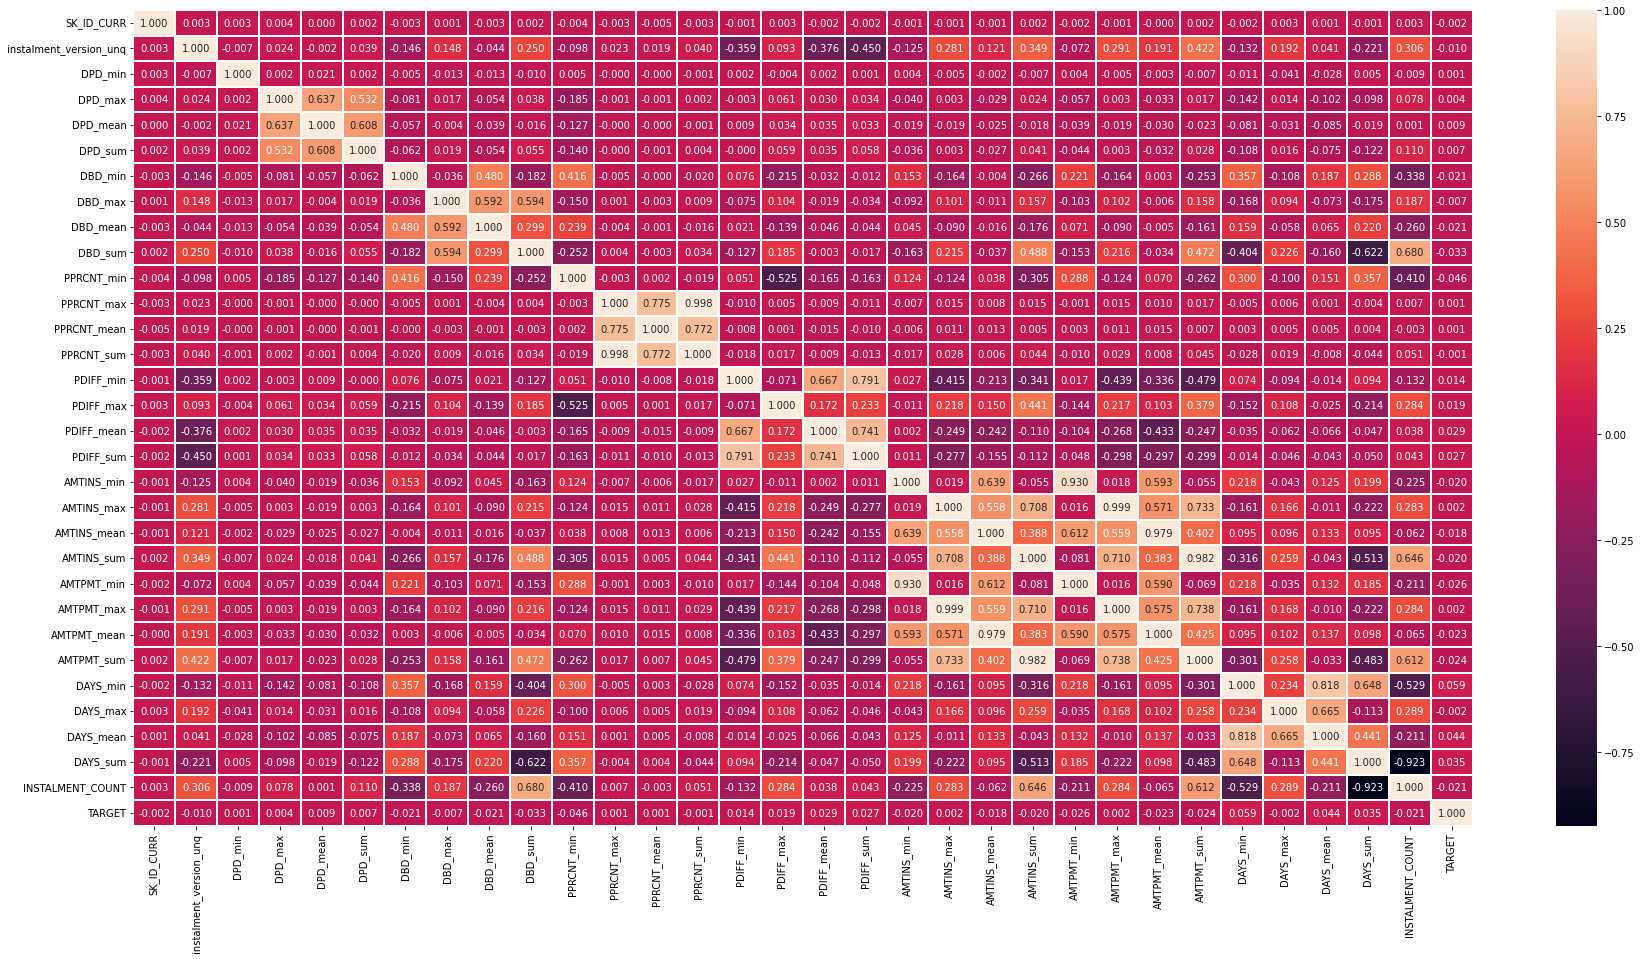

In [65]:
corr = data_agg_targ.corr()
plt.figure(figsize=(30,15))
ax = sns.heatmap(corr, linewidths=.2,annot=True,fmt=".3f")

In [66]:
# clean up memory
del data
del ad
del ax
del x
del corr
gc.collect()

82502

# EDA of Credit Card Balance Data Set

This data set holds information about monthly balance snapshots of previous credit cards that the applicant has with Home Credit. Each row represents one month of a credit card balance, so a single credit card can have many rows. It contains 23 features with 3,840,312 entries.

In [67]:
credit_card_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [68]:
credit_card_balance.shape

(3840312, 23)

## Missing Values in Credit Card Balance Data Set

There are nine variables in the credit card balance data set with missing values.

In [69]:
def missing(data):
    miss = data.isnull().sum().sort_values(ascending = False)
    perc = 100*(data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    return pd.concat([miss, perc], axis = 1, keys = ['Total', 'Percent'])

In [70]:
missing(credit_card_balance)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


## Exploring Categorical Features in Credit Card Balance Data Set

In [71]:
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

In [72]:
# get categorical features
ccbal_cats = _get_categorical_features(credit_card_balance)
ccbal_cats

['NAME_CONTRACT_STATUS']

In [73]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

### Contract Status for Credit Card Balance Data Set
Most of the applicant's contract status is active and very few are in completed and signed.

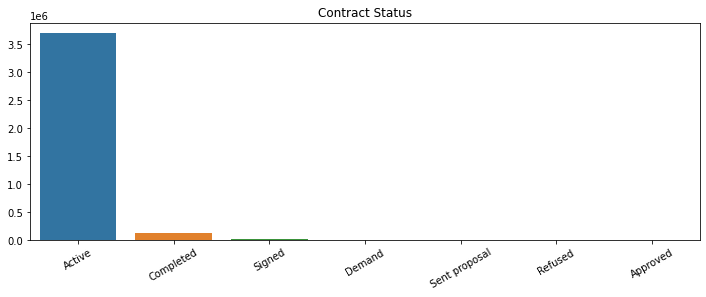

In [74]:
plot_categorical(data=credit_card_balance, col='NAME_CONTRACT_STATUS', size=[12 ,4], xlabel_angle=30, title='Contract Status')

## Checking the credit card balance during the month of the previous credit

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


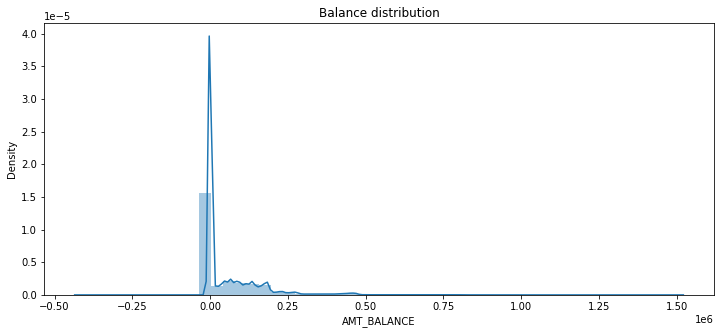

In [75]:
plt.figure(figsize=(12,5))
plt.title("Balance distribution")
ax = sns.distplot(credit_card_balance["AMT_BALANCE"])

In [76]:
# convert categorical variables to dummies
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

CCB = credit_card_balance

In [77]:
# fill msising values with 0
CCB2 = CCB.fillna(0)

In [78]:
dropthis = ['NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Demand',
           'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal',
           'NAME_CONTRACT_STATUS_Signed' ]

CCB = CCB2.drop(dropthis, axis=1)

## Number of loans per customer for Credit Card Balance Data

Most customers have only one loan.

In [79]:
no_loans = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, 
                                                                                         columns = {'SK_ID_PREV': 'NUMBER_OF_LOANS_PER_CUSTOMER'})
CCB = CCB.merge(no_loans, on = ['SK_ID_CURR'], how = 'left')

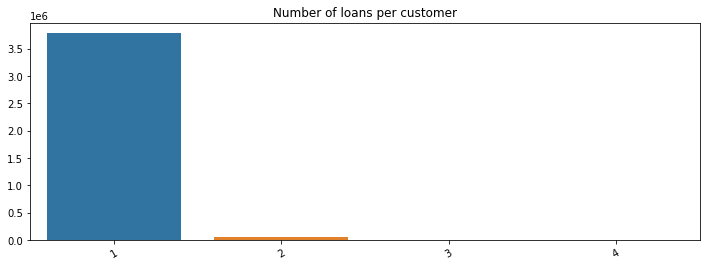

In [80]:
plot_categorical(data=CCB, col='NUMBER_OF_LOANS_PER_CUSTOMER', 
                 size=[12 ,4], xlabel_angle=30, title='Number of loans per customer')

## Average number of installments per loan per customer for Credit Card Balance Data

Most applicants have less than fifty installments per previous credit card balances.

In [81]:
no_installments = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NUMBER_OF_INSTALMENTS'})
no_installments1 = no_installments.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NUMBER_OF_INSTALMENTS': 'TOTAL_INSTALMENTS_OF_ALL_LOANS'})
CCB = CCB.merge(no_installments1, on = ['SK_ID_CURR'], how = 'left')
CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS_OF_ALL_LOANS']/CCB['NUMBER_OF_LOANS_PER_CUSTOMER']).round(2)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


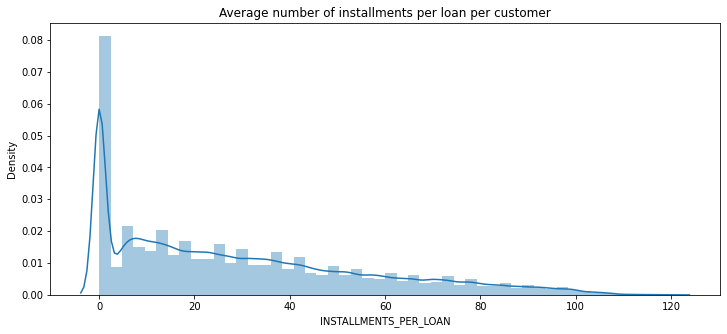

In [82]:
plt.figure(figsize=(12,5))
plt.title("Average number of installments per loan per customer")
ax = sns.distplot(CCB["INSTALLMENTS_PER_LOAN"])

## Average number of times the customer has defaulted i.e. days passed due has occurred for Credit Card Balance Data

We can see that majority of customers fall between 0-20 days past due

In [83]:
def days_past_due(DPD):
        x = DPD.tolist()
        a = 0
        for i,j in enumerate(x):
            if j != 0:
                a += 1  
        return a 

dpd = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: days_past_due(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NUMBER_OF_DPD'})
grp1 = dpd.groupby(by = ['SK_ID_CURR'])['NUMBER_OF_DPD'].mean().reset_index().rename(index = str, columns = {'NUMBER_OF_DPD' : 'DPD_COUNT'})

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


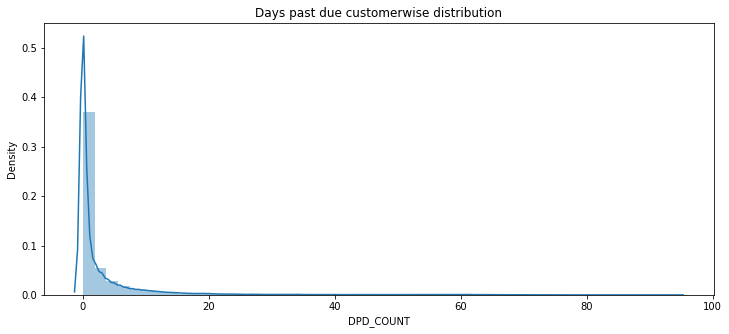

In [84]:
plt.figure(figsize=(12,5))
plt.title("Days past due customerwise distribution")
ax = sns.distplot(CCB["DPD_COUNT"])

## Looking at the Correlation between Credit Card Balance Features and 

## 

In [85]:
cc = credit_card_balance.copy()
# cc = pd.get_dummies(cc)

cc['SK_DPD_FLAG'] = cc['SK_DPD'].fillna(0).astype(bool).astype(int)
cc['SK_DPD_DEF_FLAG'] = cc['SK_DPD_DEF'].fillna(0).astype(bool).astype(int)
cc['MISSED_MIN_PAYMENTS'] = (cc.AMT_INST_MIN_REGULARITY > cc.AMT_PAYMENT_CURRENT).astype(int)

cc_rollup1 = cc.groupby(['SK_ID_CURR','SK_ID_PREV'],as_index=False).agg(days_active = ('NAME_CONTRACT_STATUS_Active','sum'),
                                                                        installments = ('CNT_INSTALMENT_MATURE_CUM','max'),
                                                                        NUMBER_OF_DPD = ('SK_DPD_FLAG','sum'),
                                                                        MISSED_MIN_PAYMENTS = ('MISSED_MIN_PAYMENTS','sum')).groupby('SK_ID_CURR').agg(
    { 'days_active':['mean','max','min'],
      'installments':['sum','max','min'],
      'NUMBER_OF_DPD':['sum'],
      'MISSED_MIN_PAYMENTS':'sum'
             })

In [86]:
cc_rollup1.columns = ['CC_'+ e[0] + "_" + e[1].upper() for e in cc_rollup1.columns.tolist()]
cc_rollup1.reset_index(inplace=True)

cc_rollup2 = cc.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV':'nunique',
    'NAME_CONTRACT_STATUS_Refused':'max',
    'MONTHS_BALANCE':["sum","mean"], 
    'AMT_BALANCE':["sum","mean","min","max"],
    'AMT_CREDIT_LIMIT_ACTUAL':["mean",'min','max'], 

    'AMT_DRAWINGS_ATM_CURRENT':["sum","mean","min","max"],
    'AMT_DRAWINGS_CURRENT':["sum","mean","min","max"], 
    'AMT_DRAWINGS_OTHER_CURRENT':["sum","mean","min","max"],
    'AMT_DRAWINGS_POS_CURRENT':["sum","mean","min","max"], 
    'AMT_INST_MIN_REGULARITY':["sum","mean","min","max"],
    'AMT_PAYMENT_CURRENT':["sum","mean","min","max"], 
    'AMT_PAYMENT_TOTAL_CURRENT':["sum","mean","min","max"],
    'AMT_RECEIVABLE_PRINCIPAL':["sum","mean","min","max"], 
    'AMT_RECIVABLE':["sum","mean","min","max"], 
    'AMT_TOTAL_RECEIVABLE':["sum","mean","min","max"],

    'CNT_DRAWINGS_ATM_CURRENT':["sum","mean"], 
    'CNT_DRAWINGS_CURRENT':["sum","mean","max"],
    'CNT_DRAWINGS_OTHER_CURRENT':["mean","max"], 
    'CNT_DRAWINGS_POS_CURRENT':["sum","mean","max"],
    'CNT_INSTALMENT_MATURE_CUM':["mean","max","min"],    
    'SK_DPD':[np.median,'max','min'], 
    'SK_DPD_DEF':[np.median,'max','min']})

cc_rollup2.columns = ['CC_'+ e[0] + "_" + e[1].upper() for e in cc_rollup2.columns.tolist()]
cc_rollup2['CASH_TO_CARD_RATIO'] = (cc_rollup2['CC_AMT_DRAWINGS_ATM_CURRENT_SUM'] / cc_rollup2['CC_AMT_DRAWINGS_CURRENT_SUM'])
cc_rollup2.reset_index(inplace=True)

cc_all = cc_rollup1.merge(cc_rollup2,on='SK_ID_CURR',how='outer')

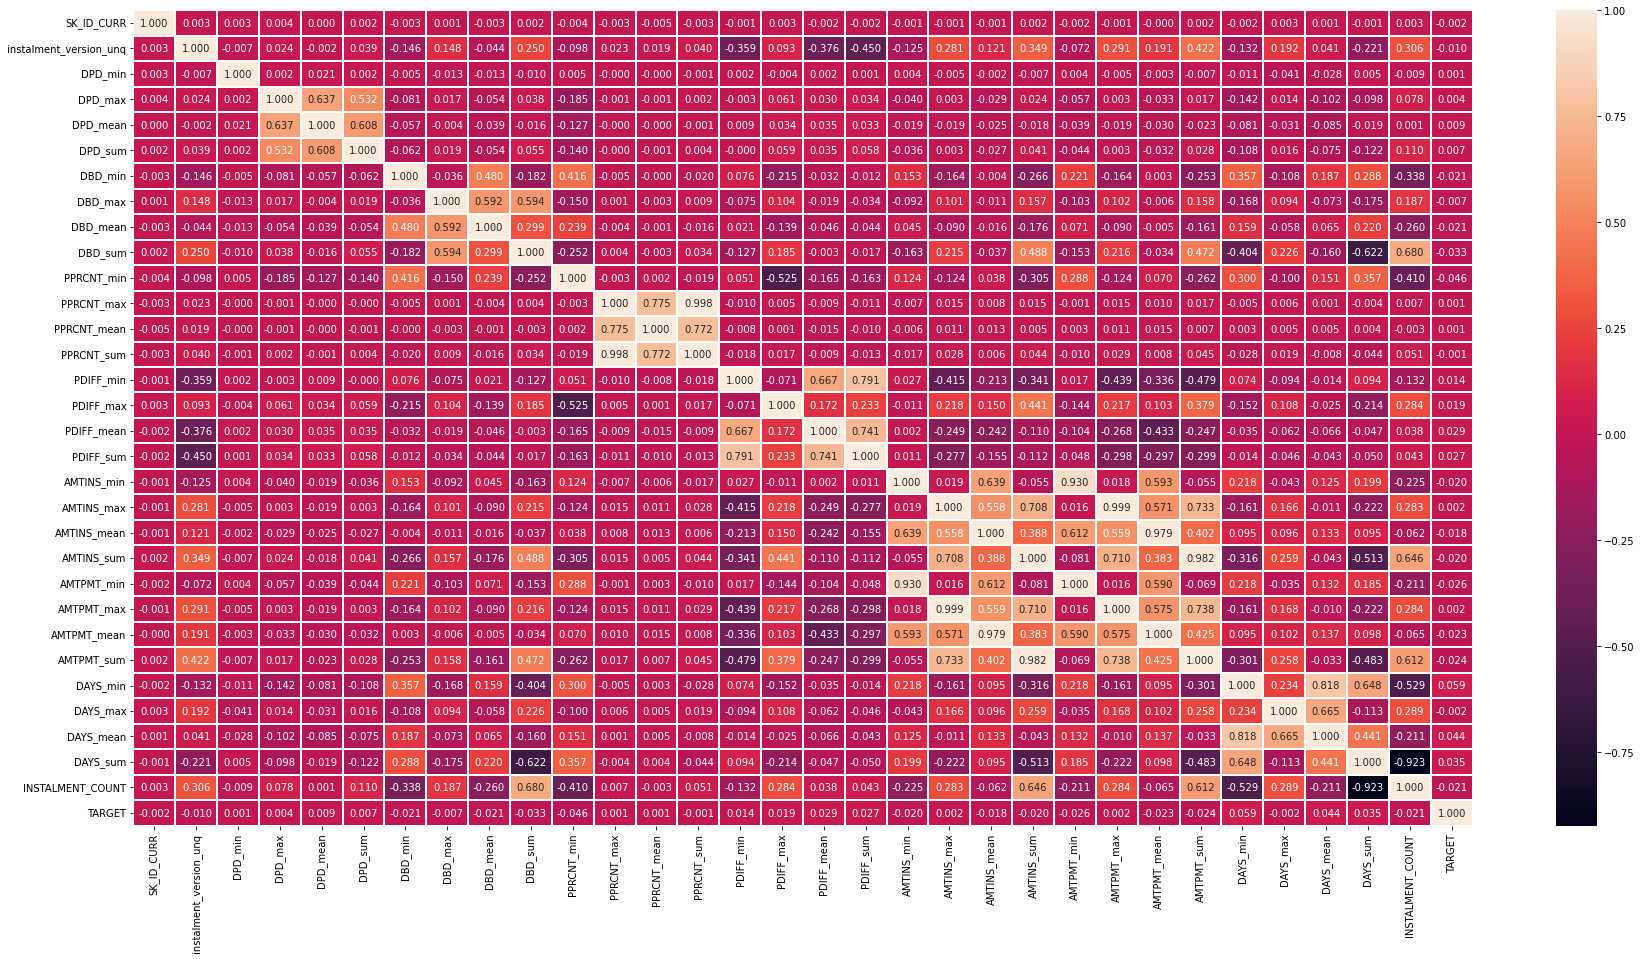

In [87]:
cc_all_targ = cc_all.merge(right=application_train[['SK_ID_CURR','TARGET']], how='inner', on='SK_ID_CURR')

corr = data_agg_targ.corr()
plt.figure(figsize=(30,15))
ax = sns.heatmap(corr, linewidths=.2,annot=True,fmt=".3f")

In [88]:
# clean up memory
del credit_card_balance
del ccbal_cats
del dropthis
del CCB
del CCB2
del no_installments
del no_installments1

gc.collect()

5799

# EDA for Bureau and Bureau Balance Data

**BUREAU**   
> **Description:** All clients' previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.  
> **Level of Data:** Every unique credit is identified by *SK_BUREAU_ID* and the client from of our loan sample is identified by *SK_ID_CURR*  

**BUREAU BALANCE**
> **Description:** Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.  
> **Level of Data:**

## Shape of Bureau and Bureau Balance Data

**BUREAU**
* The dataset contains 17 columns including the loan and the client identifier columns. These represent the status of the loan, application timeline, and credit information with repayment details.
* There is credit information available for 305,811 clients from our loan sample 
* There are a total of 1,716,428 loans from the past


In [89]:
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [90]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


**BUREAU BALANCE**
* The table contains 27,299,925 unique at a *SK_ID_BUREAU* and *MONTH_BALANCE* (month relative to the application date)
* From the day the credit was created till the date of the application with home credit - the table has monthly ststus of the previous credit
* In the Status column
| Status | Description |
|--------|-------------|
| C | Completed|
| X | Unknown|
| 0 | No DPD |
|1|DPD 0-30|
| 2 | DPD 31-60|
| 3 | DPD 61-90|
| 4 | DPD 91-120|
|5| DPD 120+ /Closed/Sold |

In [91]:
bureau_balances = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
bureau_balances.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [92]:
bureau_balances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


## Data Cleaning / Missing Values for Bureau and Bureau Balance Data
**BUREAU**
* The table does not have any data type discrepancies
* For missing values, we will not impute them as the data mining models are capable of handling the missing values


In [93]:
print("Checking the Missing value % in Bureau data columns")
round(bureau.isna().sum() * 100/len(bureau),2)

Checking the Missing value % in Bureau data columns


SK_ID_CURR                 0.00
SK_ID_BUREAU               0.00
CREDIT_ACTIVE              0.00
CREDIT_CURRENCY            0.00
DAYS_CREDIT                0.00
CREDIT_DAY_OVERDUE         0.00
DAYS_CREDIT_ENDDATE        6.15
DAYS_ENDDATE_FACT         36.92
AMT_CREDIT_MAX_OVERDUE    65.51
CNT_CREDIT_PROLONG         0.00
AMT_CREDIT_SUM             0.00
AMT_CREDIT_SUM_DEBT       15.01
AMT_CREDIT_SUM_LIMIT      34.48
AMT_CREDIT_SUM_OVERDUE     0.00
CREDIT_TYPE                0.00
DAYS_CREDIT_UPDATE         0.00
AMT_ANNUITY               71.47
dtype: float64

**BUREAU BALANCES**

* For records, where the status of the loan is unknown ('X'), we replace it with 0 or No DPD flag
* STATUS column has numeric flags, hence the variable is ordinal

In [94]:
print("Checking the Missing value % in Bureau Balances data columns")
round(bureau_balances.isna().sum() * 100/len(bureau_balances),2)

Checking the Missing value % in Bureau Balances data columns


SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64

## Feature Engineering for Bureuau and Bureau Balance Data

In [95]:
merged = pd.merge(bureau,bureau_balances,how='inner',on='SK_ID_BUREAU')
merged = merged[merged['STATUS'] != "C"]
merged['STATUS'] = merged['STATUS'].replace({'X':0}).astype(int)

pivoted_balance = merged.groupby(['SK_ID_CURR','SK_ID_BUREAU','CREDIT_ACTIVE','STATUS'],as_index=False).size().pivot(index=['SK_ID_CURR','SK_ID_BUREAU','CREDIT_ACTIVE'],columns='STATUS',values='size').reset_index().fillna(0)
pivoted_balance['total_defaults'] = pivoted_balance.iloc[:,3:].sum(axis=1)
pivoted_balance['%_total_defaults'] = pivoted_balance['total_defaults']*100 / (pivoted_balance['total_defaults'] + pivoted_balance[0])
pivoted_balance['avg_default_months'] = ((pivoted_balance[0]*0 + pivoted_balance[1]*1 + pivoted_balance[2]*2 + pivoted_balance[3]*3 + pivoted_balance[4]*4 + pivoted_balance[5]*5)/(pivoted_balance[0] + pivoted_balance[1] + pivoted_balance[2] + pivoted_balance[3] + pivoted_balance[4] + pivoted_balance[5])).fillna(0)

bureau_balance_overall = pivoted_balance.drop(columns=['CREDIT_ACTIVE']).groupby(['SK_ID_CURR']).agg({
    0:['sum','max'],
    1:['sum','max'],
    2:['sum','max'],
    3:['sum','max'],
    4:['sum','max'],
    5:['sum','max'],
    'total_defaults':['sum','max',np.mean],
    '%_total_defaults':[np.mean,'max'],
    'avg_default_months':[np.median,'max']})

bureau_balance_overall.columns = bureau_balance_overall.columns.map(lambda x: str(x[0]) + '_' + str(x[1]))
bureau_balance_overall.reset_index(inplace=True)

bureau_balance_status = pivoted_balance.groupby(['SK_ID_CURR',"CREDIT_ACTIVE"]).agg({
    0:['sum','max'],
    1:['sum','max'],
    2:['sum','max'],
    3:['sum','max'],
    4:['sum','max'],
    5:['sum','max'],
    'total_defaults':['sum','max',np.mean],
    '%_total_defaults':[np.mean,'max'],
    'avg_default_months':[np.median,'max']})

bureau_balance_status.columns = bureau_balance_status.columns.map(lambda x: str(x[0]) + '_' + str(x[1]))
bureau_balance_status.reset_index(inplace=True)

bureau_balance_status = bureau_balance_status.pivot_table(index='SK_ID_CURR',columns='CREDIT_ACTIVE',fill_value=0)
bureau_balance_status.columns = bureau_balance_status.columns.map('_'.join)
bureau_balance_status.reset_index(inplace=True)

bureau['loan_duration'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
bureau['CNT_CREDIT_PROLONG_Flag'] = bureau['CNT_CREDIT_PROLONG'].astype(bool)
bureau['CURRENT_MAX_OVERDUE'] = (bureau['AMT_CREDIT_MAX_OVERDUE'] == bureau['AMT_CREDIT_SUM_OVERDUE']).astype(int)
bureau['CURRENT_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].apply(lambda x: 0 if x == 0 else 1)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0).apply(lambda x: -1*x if x<0 else x)
bureau['HAS_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].astype(bool).astype(int)
bureau['CREDIT_DEBT_RATIO'] = bureau[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].fillna(0).apply(lambda x: ((100 if (x[1]/x[0])>100 else (x[1]/x[0])) if x[0] else 1) if x[1] else 0,axis=1)

bureau_categories = pd.get_dummies(bureau.iloc[:,[0,1,2,3,14]])
bureau_categories = bureau_categories.drop(columns='SK_ID_BUREAU').groupby(['SK_ID_CURR'],as_index=False).sum()
bureau_categories['total_loans'] = bureau_categories.iloc[:,1:5].sum(axis=1)

data2 = bureau.sort_values(by=['SK_ID_CURR','DAYS_CREDIT']).reset_index(drop=True)
data2[['DAYS_CREDIT_Diff','DAYS_CREDIT_ENDDATE_Diff','DAYS_ENDDATE_FACT_Diff']] = data2.groupby(['SK_ID_CURR'])[['DAYS_CREDIT','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT']].diff()

bureau_application_timelines = data2.groupby(['SK_ID_CURR'],as_index=False).agg(latest_application = ('DAYS_CREDIT','max'),
                                                          oldest_application = ('DAYS_CREDIT','min'),
                                                          max_days_overdue = ('CREDIT_DAY_OVERDUE','max'),
                                                          avg_days_overdue = ('CREDIT_DAY_OVERDUE',np.median),
                                                          last_credit_enddate = ('DAYS_ENDDATE_FACT','max'),
                                                          avg_difference_applications = ('DAYS_CREDIT_Diff',np.mean),
                                                          min_difference_applications = ('DAYS_CREDIT_Diff','min'),
                                                          avg_loan_duration = ('loan_duration',np.mean),
                                                          max_loan_duration = ('loan_duration','max'))

bureau_application_timelines_active = data2.loc[data2.CREDIT_ACTIVE =='Active'].groupby(['SK_ID_CURR'],
                                                  as_index=False).agg(oldest_application_active = ('DAYS_CREDIT','min'),
                                                                      max_days_overdue_active = ('CREDIT_DAY_OVERDUE','max'),
                                                                      avg_days_overdue_active = ('CREDIT_DAY_OVERDUE',np.median),
                                                                      earliest_credit_enddate_active = ('DAYS_CREDIT_ENDDATE','min'),
                                                                      latest_credit_enddate_active = ('DAYS_CREDIT_ENDDATE','max'),
                                                                      avg_difference_applications_active = ('DAYS_CREDIT_Diff',np.mean),
                                                                      min_difference_applications_active = ('DAYS_CREDIT_Diff','min'),
                                                                      avg_difference_enddate_active = ('DAYS_CREDIT_ENDDATE_Diff',np.mean),
                                                                      avg_loan_duration_active = ('loan_duration',np.mean),
                                                                      max_loan_duration_active = ('loan_duration','max'))

bureau_application_timelines_closed = data2.loc[data2.CREDIT_ACTIVE =='Closed'].groupby(['SK_ID_CURR'],
                                                  as_index=False).agg(oldest_application_closed = ('DAYS_CREDIT','min'),
                                                                      lastest_application_closed = ('DAYS_CREDIT','max'),
                                                                      max_days_overdue_closed = ('CREDIT_DAY_OVERDUE','max'),
                                                                      avg_days_overdue_closed = ('CREDIT_DAY_OVERDUE',np.median),
                                                                      earliest_credit_enddate_closed = ('DAYS_ENDDATE_FACT','min'),
                                                                      latest_credit_enddate_closed = ('DAYS_ENDDATE_FACT','max'),
                                                                      avg_difference_applications_closed = ('DAYS_CREDIT_Diff',np.mean),
                                                                      min_difference_applications_closed = ('DAYS_CREDIT_Diff','min'),
                                                                      avg_difference_enddate_closed = ('DAYS_ENDDATE_FACT_Diff',np.mean),
                                                                      avg_loan_duration_closed = ('loan_duration',np.mean),
                                                                      max_loan_duration_closed = ('loan_duration','max'))

bureau_prolong_ovrl = bureau.groupby(['SK_ID_CURR'],as_index=False).agg(per_prolonged = ('CNT_CREDIT_PROLONG_Flag',np.mean),
                                                                 total_prolonged = ('CNT_CREDIT_PROLONG','sum'))

bureau_prolong_status = bureau.groupby(['SK_ID_CURR','CREDIT_ACTIVE'],as_index=False).agg(
    per_prolonged = ('CNT_CREDIT_PROLONG_Flag',np.mean),
    total_prolonged = ('CNT_CREDIT_PROLONG','sum'))
bureau_prolong_status = bureau_prolong_status.pivot_table(index='SK_ID_CURR',columns='CREDIT_ACTIVE',fill_value=0)
bureau_prolong_status.columns = bureau_prolong_status.columns.map('_'.join)
bureau_prolong_status.reset_index(inplace=True)

bureau_amt_overall = bureau.groupby(['SK_ID_CURR'],as_index=False).agg(
    AMT_CREDIT_MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','sum'),
    MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','max'),
    CURRENT_OVERDUE = ('AMT_CREDIT_SUM_OVERDUE','sum'),
    CURRENT_MAX_OVERDUES = ('CURRENT_MAX_OVERDUE','sum'),
    CURRENT_OVERDUES = ('CURRENT_OVERDUE','sum'),
    CURRENT_OVERDUE_AVG = ('CURRENT_OVERDUE',np.mean),
    AMT_CREDIT_SUM_DEBT = ('AMT_CREDIT_SUM_DEBT','sum'),
    AMT_CREDIT_SUM = ('AMT_CREDIT_SUM','sum'))

bureau_amt_overall['CREDIT_DEBT_RATIO'] =  bureau_amt_overall[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].fillna(0).apply(lambda x: ((100 if (x[1]/x[0])>100 else (x[1]/x[0])) if x[0] else 1) if x[1] else 0,axis=1)

bureau_amt_status = bureau.groupby(['SK_ID_CURR','CREDIT_ACTIVE']).agg(
    AMT_CREDIT_MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','sum'),
    MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','max'),
    AMT_CREDIT_SUM_DEBT = ('AMT_CREDIT_SUM_DEBT','sum'),
    AMT_CREDIT_SUM = ('AMT_CREDIT_SUM','sum'))

bureau_amt_status['CREDIT_DEBT_RATIO'] =  bureau_amt_status[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].fillna(0).apply(lambda x: ((100 if (x[1]/x[0])>100 else (x[1]/x[0])) if x[0] else 1) if x[1] else 0,axis=1)
bureau_amt_status = bureau_amt_status.pivot_table(index='SK_ID_CURR',columns='CREDIT_ACTIVE',fill_value=0)
bureau_amt_status.columns = bureau_amt_status.columns.map('_'.join)
bureau_amt_status.reset_index(inplace=True)

bureau_data_all = bureau_categories.merge(bureau_application_timelines,how='outer',on='SK_ID_CURR').merge(
    bureau_application_timelines_active,how='outer',on='SK_ID_CURR').merge(
    bureau_application_timelines_closed,how='outer',on='SK_ID_CURR').merge(
    bureau_prolong_ovrl,how='outer',on='SK_ID_CURR').merge(
    bureau_prolong_status,how='outer',on='SK_ID_CURR').merge(
    bureau_amt_overall,how='outer',on='SK_ID_CURR').merge(
    bureau_amt_status,how='outer',on='SK_ID_CURR').merge(
    bureau_balance_overall,how='outer',on='SK_ID_CURR').merge(
    bureau_balance_status,how='outer',on='SK_ID_CURR')

application_train = pd.read_csv(r'../input/home-credit-default-risk/application_train.csv').iloc[:,0:2]
application_train.head()

bureau_target = application_train.merge(bureau_data_all,how='left',on='SK_ID_CURR')
bureau_target.head()

,SK_ID_CURR,TARGET,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,...,total_defaults_max_Closed,total_defaults_max_Sold,total_defaults_mean_Active,total_defaults_mean_Bad debt,total_defaults_mean_Closed,total_defaults_mean_Sold,total_defaults_sum_Active,total_defaults_sum_Bad debt,total_defaults_sum_Closed,total_defaults_sum_Sold
0,100002,1,2.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,...,20.0,0.0,9.0,0.0,11.5,0.0,18.0,0.0,69.0,0.0
1,100003,0,1.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
bureau_target = application_train.merge(bureau_data_all,how='left',on='SK_ID_CURR')
bureau_target.head()

,SK_ID_CURR,TARGET,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,...,total_defaults_max_Closed,total_defaults_max_Sold,total_defaults_mean_Active,total_defaults_mean_Bad debt,total_defaults_mean_Closed,total_defaults_mean_Sold,total_defaults_sum_Active,total_defaults_sum_Bad debt,total_defaults_sum_Closed,total_defaults_sum_Sold
0,100002,1,2.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,...,20.0,0.0,9.0,0.0,11.5,0.0,18.0,0.0,69.0,0.0
1,100003,0,1.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Drill down on a few important features**
1. **latest_application** - Days when the most recent credit was applied for
2. **earliest_credit_enddate_active** - Earliest end date of an active credit
3. **oldest_application_active** - Oldest start date of an active credit
4. **lastest_application_closed** - Days since last closed credit
5. **avg_difference_enddate_active** - Average difference between end dates of active credits
6. **avg_difference_applications** - Average difference between applications of credits
7. **avg_difference_enddate_closed** - Average difference between end dates of closed credits
8. **CREDIT_DEBT_RATIO_Active** - Credit to Debt ration of all the active credits
9. **avg_loan_duration_closed** - Average credit timeperiod of the closed credits
10. **avg_difference_applications_closed** - Average difference between applications of closed credits
11. **AMT_CREDIT_SUM** - Total credit applied for
12. **avg_loan_duration** - Average duration of credits
13. **latest_credit_enddate_active** - Lateset end date of active credits
14. **AMT_CREDIT_SUM_Active** - Credit amount of active credits
15. **earliest_credit_enddate_closed** - last closed credit date
16. **avg_difference_applications_active** - Difference between active applications
17. **CREDIT_DEBT_RATIO** - Credit to debt ratio
18. **oldest_application_closed** - Earliest closed credit application date
19. **oldest_application** - oldest credit start date 
20. **min_difference_applications_active** - Minimum difference between start dates of two consecutive active credits
21. **min_difference_applications** - Minimum days difference between two consecutive credits
22. **AMT_CREDIT_SUM_Closed** - Total credit in the closed credits
23. **max_loan_duration_closed** - Maximum duration of the closed credits
24. **min_difference_applications_closed** - Minmum difference between start dates of two consecutive closed credits
25. **avg_loan_duration_active** - Average duration of active credits
26. **max_loan_duration** - Maximum duration of credits
27. **MAX_OVERDUE** - Maximum amount overdue amongst all credits
28. **latest_credit_enddate_closed** - Latest end date of a closed credit
29. **last_credit_enddate** - Last closed credit date
30. **max_loan_duration_active**- Maximum duration of an active credit
31. **AMT_CREDIT_SUM_DEBT_Active** - Total debt in active credits
32. **AMT_CREDIT_SUM_DEBT** - Total Debt
33. **total_defaults_mean** - Average defaults per credit

In [97]:
important_features = list(['latest_application','earliest_credit_enddate_active',
                           'oldest_application_active','lastest_application_closed','avg_difference_enddate_active','avg_difference_applications','avg_difference_enddate_closed','CREDIT_DEBT_RATIO_Active','avg_loan_duration_closed','avg_difference_applications_closed','AMT_CREDIT_SUM','avg_loan_duration','latest_credit_enddate_active','AMT_CREDIT_SUM_Active','earliest_credit_enddate_closed','avg_difference_applications_active','CREDIT_DEBT_RATIO','oldest_application_closed','oldest_application','min_difference_applications_active','min_difference_applications','AMT_CREDIT_SUM_Closed','max_loan_duration_closed','min_difference_applications_closed','avg_loan_duration_active','max_loan_duration','MAX_OVERDUE','latest_credit_enddate_closed','last_credit_enddate','max_loan_duration_active','AMT_CREDIT_SUM_DEBT_Active','AMT_CREDIT_SUM_DEBT','total_defaults_mean'])

## Correlation Plot for Bureau and Bureau Balance Data

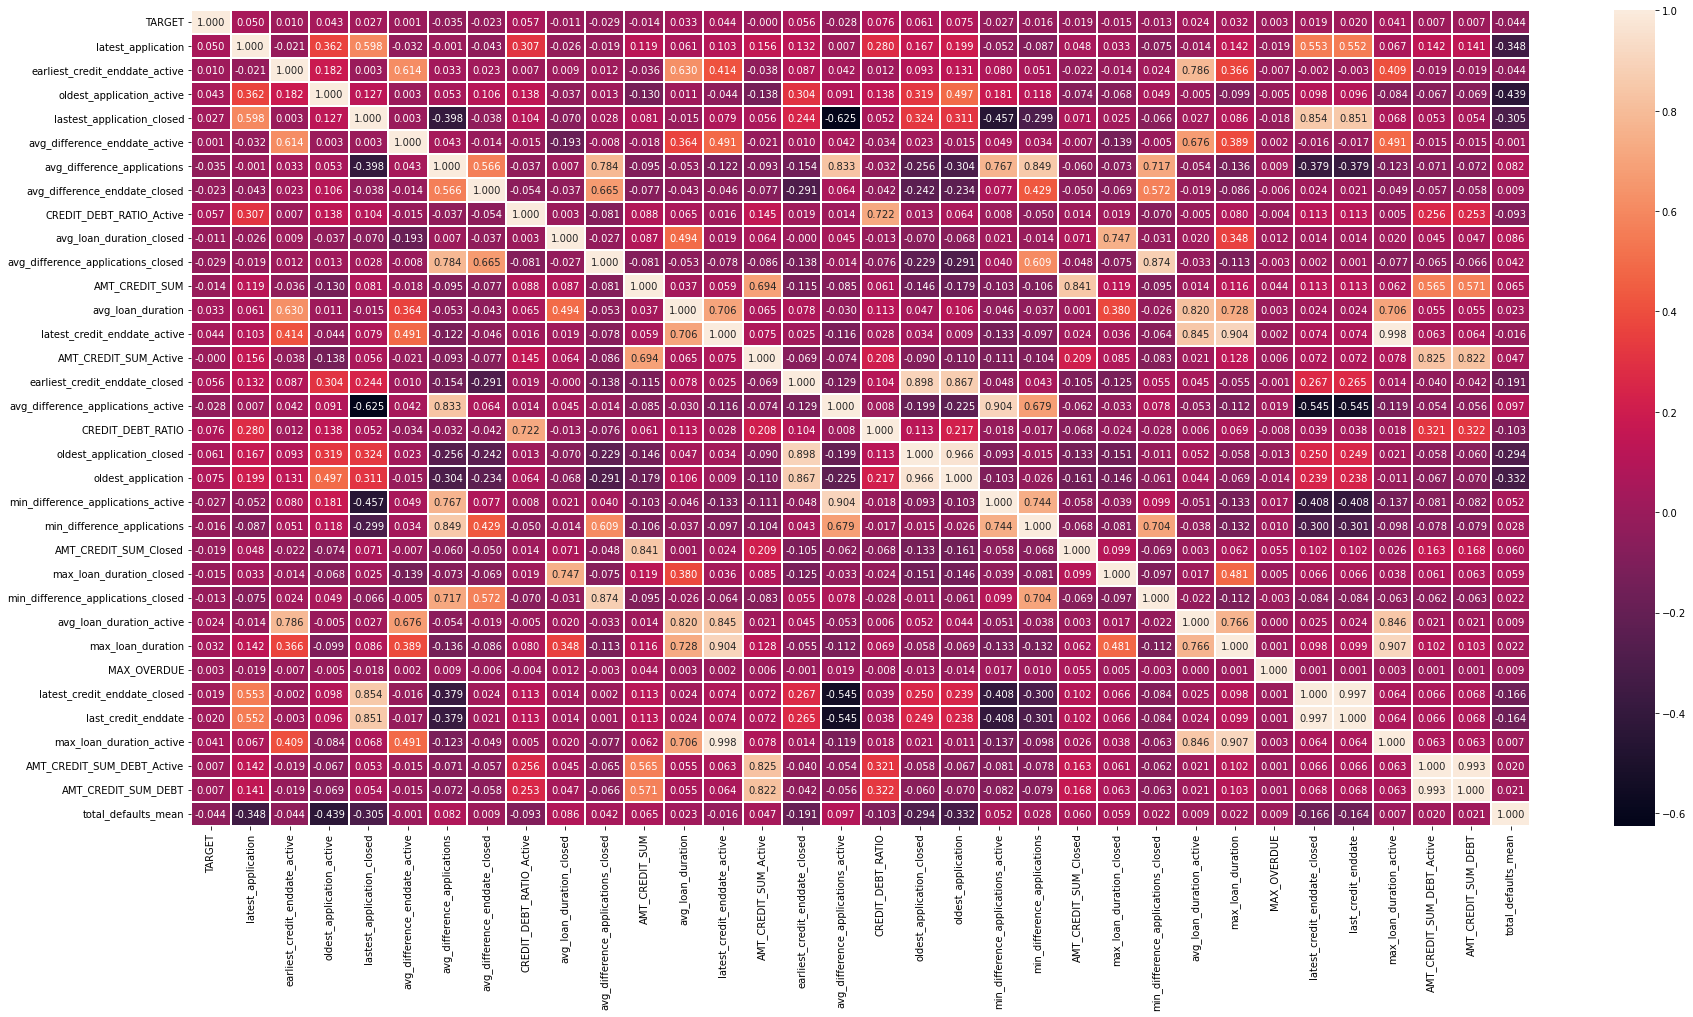

In [98]:
corr = bureau_target[['TARGET']+important_features].corr()
plt.figure(figsize=(30,15))
ax = sns.heatmap(corr, linewidths=.2,annot=True,fmt=".3f")

## Frequency Distribution Plots w.r.t. Target for Bureau and Bureau Balance Data

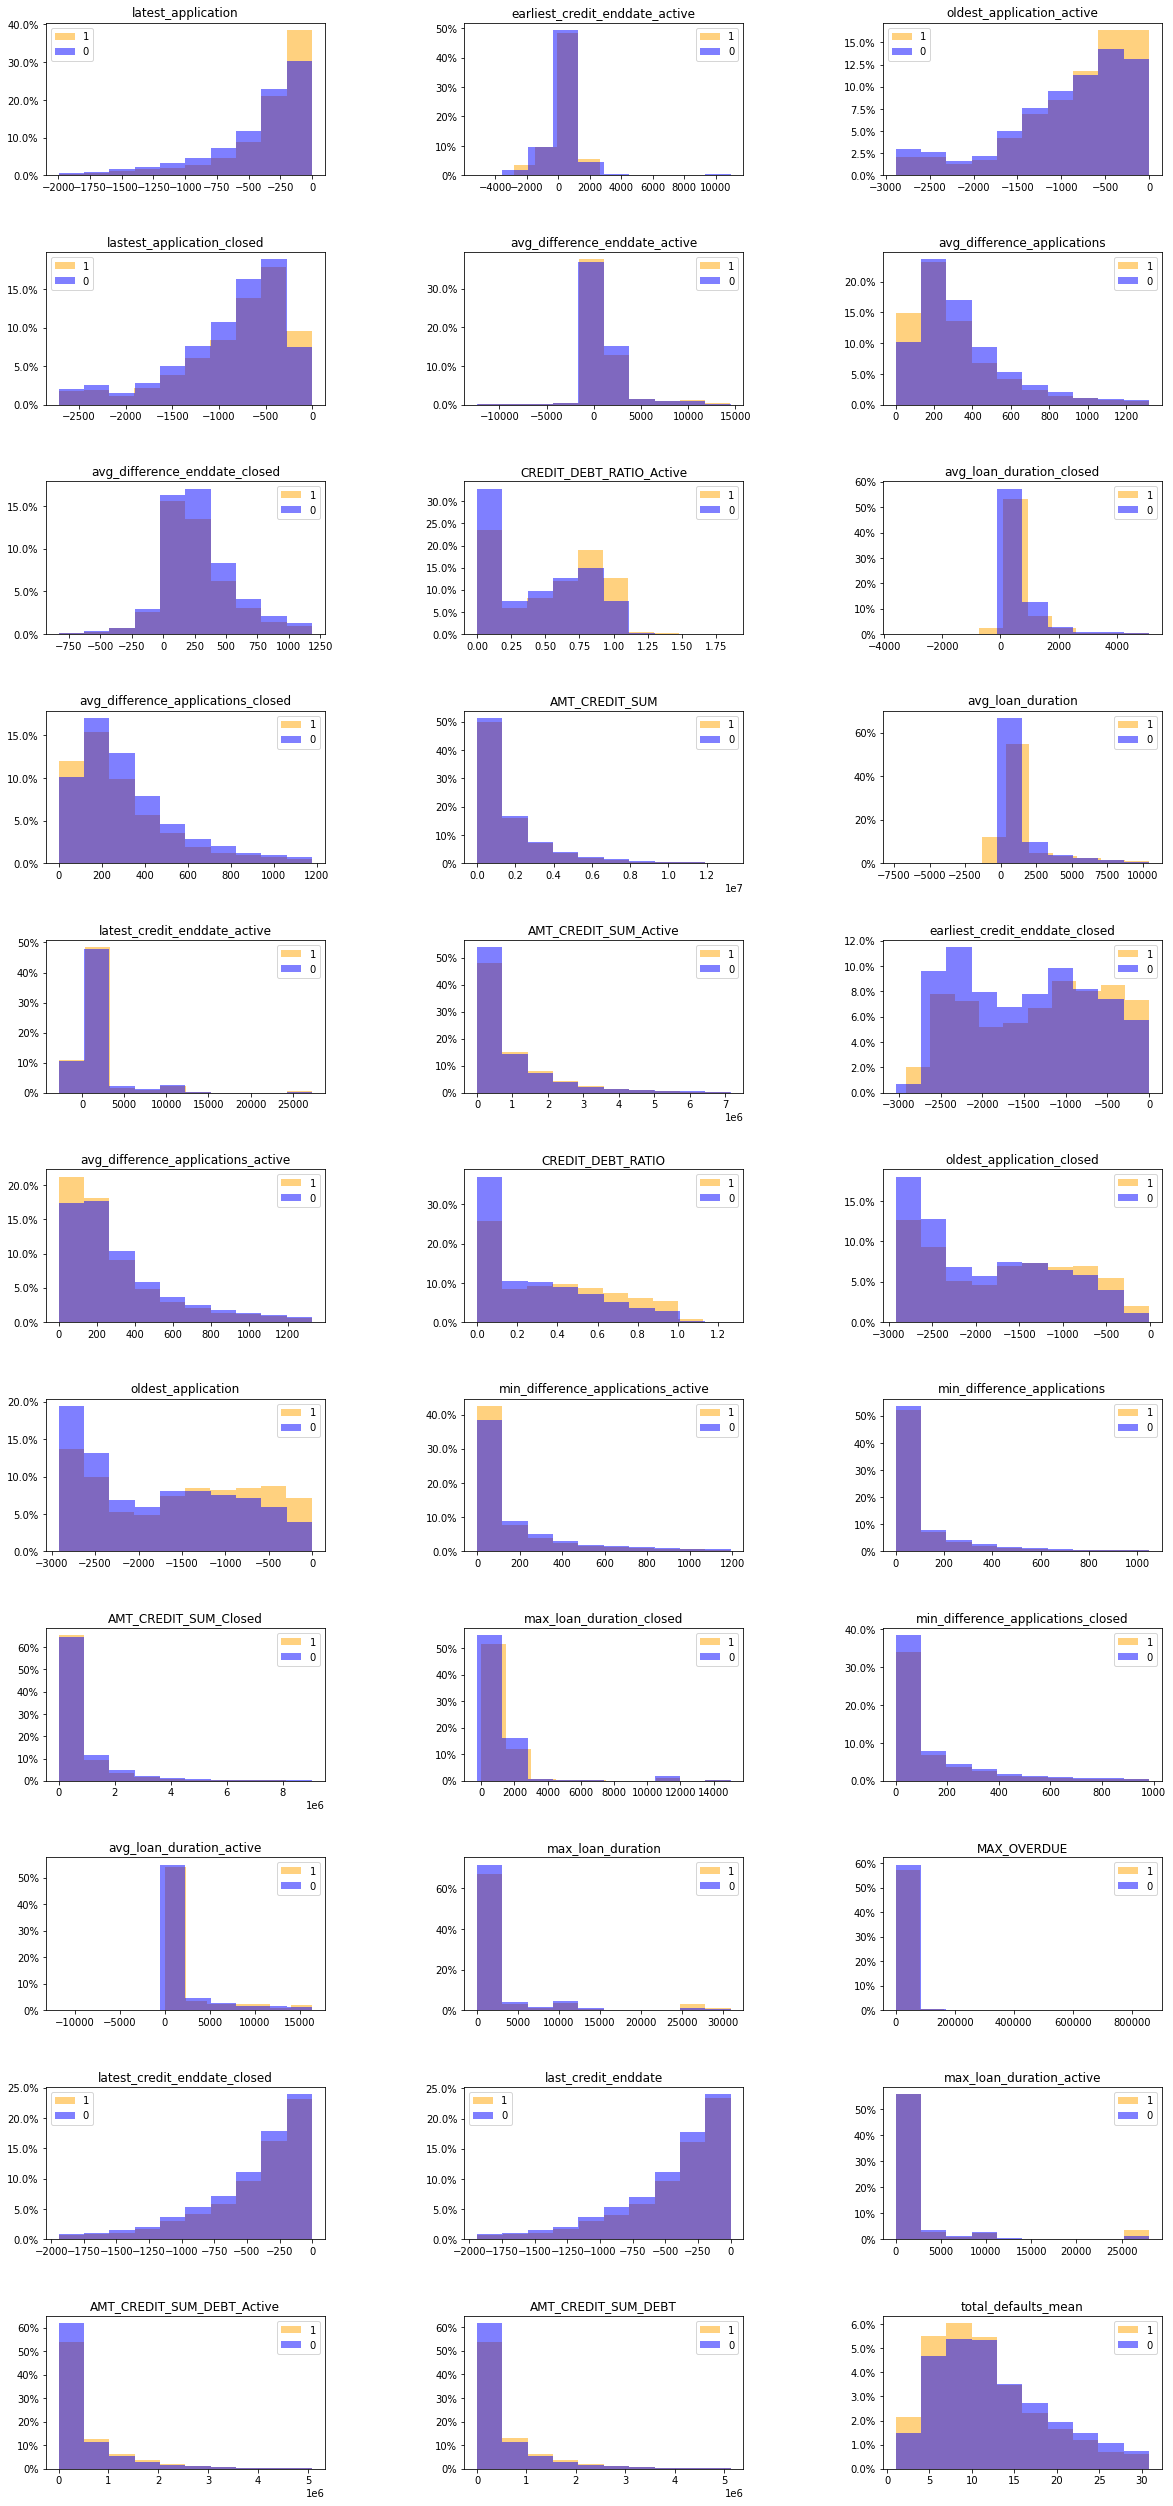

In [99]:
fig = plt.figure(figsize=(20,45))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(1,34):
    ax = fig.add_subplot(11, 3, i)
    data1 = bureau_target[(np.abs(stats.zscore(bureau_target[important_features[i-1]].fillna(0))) < 3)].loc[bureau_target['TARGET']==1,important_features[i-1]]
    data2 = bureau_target[(np.abs(stats.zscore(bureau_target[important_features[i-1]].fillna(0))) < 3)].loc[bureau_target['TARGET']==0,important_features[i-1]]
    ax.hist(data1, color='orange',alpha=0.5,label='1',weights=np.ones(len(data1)) / len(data1))
    ax.hist(data2, color='blue',alpha=0.5,label='0',weights=np.ones(len(data2)) / len(data2))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax.legend(loc=0)
    plt.title("{0}".format(important_features[i-1]))

## Distribution of Features for Bureau and Bureau Balance Data

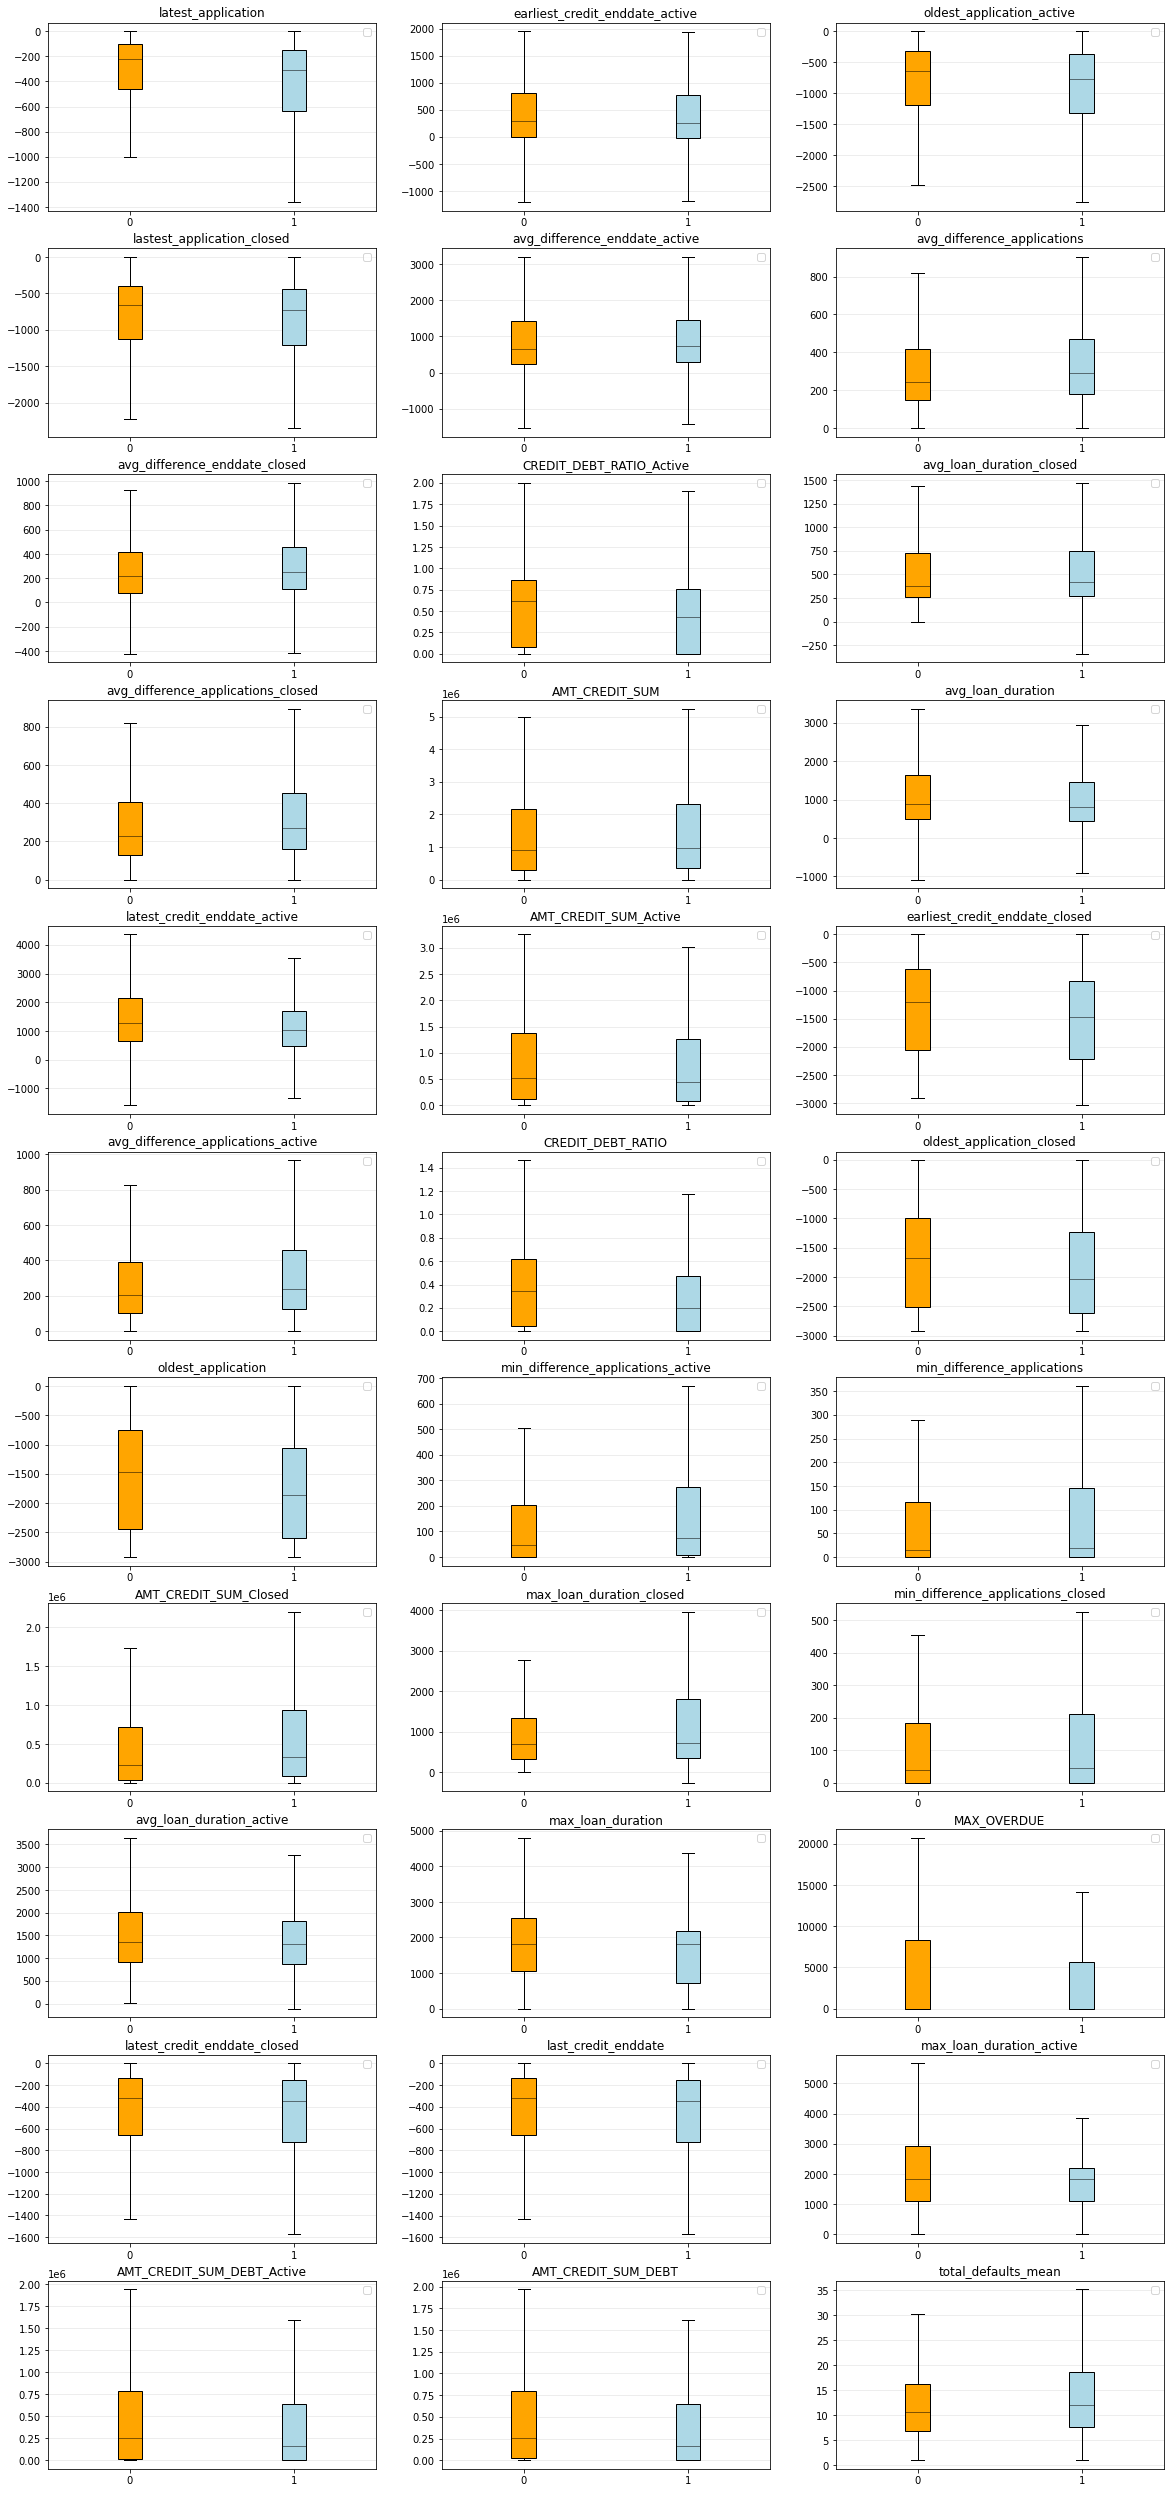

In [100]:
fig = plt.figure(figsize=(20,45))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(1,34):
    ax = fig.add_subplot(11, 3, i)
    data1 = bureau_target.loc[bureau_target['TARGET']==1,important_features[i-1]]
    data1 = data1[~data1.isna()]
    data2 = bureau_target.loc[bureau_target['TARGET']==0,important_features[i-1]]
    data2 = data2[~data2.isna()]
    bp = ax.boxplot([data1,data2],labels=['0','1'],showfliers=False,patch_artist=True,medianprops={"color": "black", "linewidth": 0.5})
    colors = ['orange','lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.legend(loc=0)
    plt.title("{0}".format(important_features[i-1]))